In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx
import progressbar
import astropy.cosmology as apc
import matplotlib.colors as mpc
import matplotlib.cm as cm

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
#ok, lets calculate the mass at different distances for different scales respect to R_Optical

def MassScale(gal,central):
    uniqueID = int(127*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(127*1e6+central)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    Mass1G = []
    Mass5G = []
    Mass25G =[]
    
    Mass1S = []
    Mass5S = []
    Mass25S = []
    
    Mass1DM = []
    Mass5DM = []
    Mass25DM = [] 
    
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][central]
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snap, iddC = split_unique_id(int(mC))
        
        optRad = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        cenPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        
        delta = galPos - cenPos
        r = np.sqrt(np.sum(delta**2.))
        if r>2*r200:
            break
        
        offGas = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        offDM = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(snap)][idd].astype('int')
        offStars = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
        
        MassG = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][offGas[0]:offGas[1]]
#         MassDM = sim['SnapNumber_{}/PartType1/Masses'.format(snap)][offDM[0]:offDM[1]]
        MassDM = sim['SnapNumber_128/Header/MassTable'][1] * np.ones(offDM[1]-offDM[0])
        MassStars = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][offStars[0]:offStars[1]]
        
        posG = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][offGas[0]:offGas[1]]
        posDM = sim['SnapNumber_{}/PartType1/Coordinates'.format(snap)][offDM[0]:offDM[1]]
        posStars = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][offStars[0]:offStars[1]]
        
        XG, YG, ZG = posG[:,0] - galPos[0], posG[:,1] - galPos[1], posG[:,2] - galPos[2]
        XDM, YDM, ZDM = posDM[:,0] - galPos[0], posDM[:,1] - galPos[1], posDM[:,2] - galPos[2]
        XS, YS, ZS = posStars[:,0] - galPos[0], posStars[:,1] - galPos[1], posStars[:,2] - galPos[2]
        
        rG = np.sqrt(XG**2+YG**2+ZG**2)
        rDM = np.sqrt(XDM**2+YDM**2+ZDM**2)
        rS = np.sqrt(XS**2+YS**2+ZS**2)
        
        i1G = np.where((rG<optRad) & (rG>optRad*0.5))[0]
        i5G = np.where((rG<optRad*0.5) & (rG>optRad*0.25))[0]
        i25G = np.where(rG<optRad*0.25)[0]
        
        i1DM = np.where((rDM<optRad) & (rDM>optRad*0.5))[0]
        i5DM = np.where((rDM<optRad*0.5) & (rDM>optRad*0.25))[0]
        i25DM = np.where(rDM<optRad*0.25)[0]
        
        i1S = np.where((rS<optRad) & (rS>optRad*0.5))[0]
        i5S = np.where((rS<optRad*0.5) & (rS>optRad*0.25))[0]
        i25S = np.where(rS<optRad*0.25)[0]
        
        Mass1G.append(np.sum(MassG[i1G])*1e10)
        Mass5G.append(np.sum(MassG[i5G])*1e10)
        Mass25G.append(np.sum(MassG[i25G])*1e10)
        
        Mass1DM.append(np.sum(MassDM[i1DM])*1e10)
        Mass5DM.append(np.sum(MassDM[i5DM])*1e10)
        Mass25DM.append(np.sum(MassDM[i25DM])*1e10)
        
        Mass1S.append(np.sum(MassStars[i1S])*1e10)
        Mass5S.append(np.sum(MassStars[i5S])*1e10)
        Mass25S.append(np.sum(MassStars[i25S])*1e10)
        
    Mass1G = np.array(Mass1G)
    Mass5G = np.array(Mass5G)
    Mass25G = np.array(Mass25G)
    
    Mass1S = np.array(Mass1S)
    Mass5S = np.array(Mass5S)
    Mass25S = np.array(Mass25S)
    
    Mass1DM = np.array(Mass1DM)
    Mass5DM = np.array(Mass5DM)
    Mass25DM = np.array(Mass25DM)
    
    return Mass1G, Mass5G, Mass25G, Mass1S, Mass5S, Mass25S, Mass1DM, Mass5DM, Mass25DM 

In [5]:
Mass1G_4338, Mass5G_4338, Mass25G_4338, Mass1S_4338, Mass5S_4338, Mass25S_4338, Mass1DM_4338, Mass5DM_4338, Mass25DM_4338 = MassScale(4338, 4337)

In [6]:
Mass1G_4339, Mass5G_4339, Mass25G_4339, Mass1S_4339, Mass5S_4339, Mass25S_4339, Mass1DM_4339, Mass5DM_4339, Mass25DM_4339 = MassScale(4339, 4337)

In [7]:
Mass1G_4341, Mass5G_4341, Mass25G_4341, Mass1S_4341, Mass5S_4341, Mass25S_4341, Mass1DM_4341, Mass5DM_4341, Mass25DM_4341 = MassScale(4341, 4337)

In [8]:
Mass1G_4343, Mass5G_4343, Mass25G_4343, Mass1S_4343, Mass5S_4343, Mass25S_4343, Mass1DM_4343, Mass5DM_4343, Mass25DM_4343 = MassScale(4343, 4337)

In [9]:
Mass1G_4470, Mass5G_4470, Mass25G_4470, Mass1S_4470, Mass5S_4470, Mass25S_4470, Mass1DM_4470, Mass5DM_4470, Mass25DM_4470 = MassScale(4470, 4469)

In [10]:
Mass1G_4471, Mass5G_4471, Mass25G_4471, Mass1S_4471, Mass5S_4471, Mass25S_4471, Mass1DM_4471, Mass5DM_4471, Mass25DM_4471 = MassScale(4471, 4469)

In [11]:
Mass1G_4473, Mass5G_4473, Mass25G_4473, Mass1S_4473, Mass5S_4473, Mass25S_4473, Mass1DM_4473, Mass5DM_4473, Mass25DM_4473 = MassScale(4473, 4469)

In [12]:
Mass1G_4474, Mass5G_4474, Mass25G_4474, Mass1S_4474, Mass5S_4474, Mass25S_4474, Mass1DM_4474, Mass5DM_4474, Mass25DM_4474 = MassScale(4474, 4469)

In [13]:
T = h5py.File('Derived_Data.h5', 'r')

dist_4338 = T['g4338/distance'][()]
Time_4338 = T['g4338/time'][()]
cosC_4338 = T['g4338/CosCen'][()]
cosV_4338 = T['g4338/CosVel'][()]
RP_4338 = T['g4338/RP'][()]
TSt_4338 = T['g4338/TSt'][()]
gMass_4338 = T['g4338/gMass'][()]
SFR_4338 = T['g4338/SFR'][()]
starMass_4338 = T['g4338/starMass'][()]
Gas_4338 = T['g4338/Gas'][()]
RestForce_4338 = T['g4338/RestForce'][()]

dist_4339 = T['g4339/distance'][()]
Time_4339 = T['g4339/time'][()]
cosC_4339 = T['g4339/CosCen'][()]
cosV_4339 = T['g4339/CosVel'][()]
RP_4339 = T['g4339/RP'][()]
TSt_4339 = T['g4339/TSt'][()]
gMass_4339 = T['g4339/gMass'][()]
SFR_4339 = T['g4339/SFR'][()]
starMass_4339 = T['g4339/starMass'][()]
Gas_4339 = T['g4339/Gas'][()]
RestForce_4339 = T['g4339/RestForce'][()]

dist_4341 = T['g4341/distance'][()]
Time_4341 = T['g4341/time'][()]
cosC_4341 = T['g4341/CosCen'][()]
cosV_4341 = T['g4341/CosVel'][()]
RP_4341 = T['g4341/RP'][()]
TSt_4341 = T['g4341/TSt'][()]
gMass_4341 = T['g4341/gMass'][()]
SFR_4341 = T['g4341/SFR'][()]
starMass_4341 = T['g4341/starMass'][()]
Gas_4341 = T['g4341/Gas'][()]
RestForce_4341 = T['g4341/RestForce'][()]

dist_4343 = T['g4343/distance'][()]
Time_4343 = T['g4343/time'][()]
cosC_4343 = T['g4343/CosCen'][()]
cosV_4343 = T['g4343/CosVel'][()]
RP_4343 = T['g4343/RP'][()]
TSt_4343 = T['g4343/TSt'][()]
gMass_4343 = T['g4343/gMass'][()]
SFR_4343 = T['g4343/SFR'][()]
starMass_4343 = T['g4343/starMass'][()]
Gas_4343 = T['g4343/Gas'][()]
RestForce_4343 = T['g4343/RestForce'][()]

dist_4470 = T['g4470/distance'][()]
Time_4470 = T['g4470/time'][()]
cosC_4470 = T['g4470/CosCen'][()]
cosV_4470 = T['g4470/CosVel'][()]
RP_4470 = T['g4470/RP'][()]
TSt_4470 = T['g4470/TSt'][()]
gMass_4470 = T['g4470/gMass'][()]
SFR_4470 = T['g4470/SFR'][()]
starMass_4470 = T['g4470/starMass'][()]
Gas_4470 = T['g4470/Gas'][()]
RestForce_4470 = T['g4470/RestForce'][()]

dist_4471 = T['g4471/distance'][()]
Time_4471 = T['g4471/time'][()]
cosC_4471 = T['g4471/CosCen'][()]
cosV_4471 = T['g4471/CosVel'][()]
RP_4471 = T['g4471/RP'][()]
TSt_4471 = T['g4471/TSt'][()]
gMass_4471 = T['g4471/gMass'][()]
SFR_4471 = T['g4471/SFR'][()]
starMass_4471 = T['g4471/starMass'][()]
Gas_4471 = T['g4471/Gas'][()]
RestForce_4471 = T['g4471/RestForce'][()]

dist_4473 = T['g4473/distance'][()]
Time_4473 = T['g4473/time'][()]
cosC_4473 = T['g4473/CosCen'][()]
cosV_4473 = T['g4473/CosVel'][()]
RP_4473 = T['g4473/RP'][()]
TSt_4473 = T['g4473/TSt'][()]
gMass_4473 = T['g4473/gMass'][()]
SFR_4473 = T['g4473/SFR'][()]
starMass_4473 = T['g4473/starMass'][()]
Gas_4473 = T['g4473/Gas'][()]
RestForce_4473 = T['g4473/RestForce'][()]

dist_4474 = T['g4474/distance'][()]
Time_4474 = T['g4474/time'][()]
cosC_4474 = T['g4474/CosCen'][()]
cosV_4474 = T['g4474/CosVel'][()]
RP_4474 = T['g4474/RP'][()]
TSt_4474 = T['g4474/TSt'][()]
gMass_4474 = T['g4474/gMass'][()]
SFR_4474 = T['g4474/SFR'][()]
starMass_4474 = T['g4474/starMass'][()]
Gas_4474 = T['g4474/Gas'][()]
RestForce_4474 = T['g4474/RestForce'][()]

In [14]:
p1G_4338, p5G_4338, p25G_4338 = Mass1G_4338/(Mass1G_4338+Mass5G_4338+Mass25G_4338), Mass5G_4338/(Mass1G_4338+Mass5G_4338+Mass25G_4338), Mass25G_4338/(Mass1G_4338+Mass5G_4338+Mass25G_4338)
p1G_4339, p5G_4339, p25G_4339 = Mass1G_4339/(Mass1G_4339+Mass5G_4339+Mass25G_4339), Mass5G_4339/(Mass1G_4339+Mass5G_4339+Mass25G_4339), Mass25G_4339/(Mass1G_4339+Mass5G_4339+Mass25G_4339)
p1G_4341, p5G_4341, p25G_4341 = Mass1G_4341/(Mass1G_4341+Mass5G_4341+Mass25G_4341), Mass5G_4341/(Mass1G_4341+Mass5G_4341+Mass25G_4341), Mass25G_4341/(Mass1G_4341+Mass5G_4341+Mass25G_4341)
p1G_4343, p5G_4343, p25G_4343 = Mass1G_4343/(Mass1G_4343+Mass5G_4343+Mass25G_4343), Mass5G_4343/(Mass1G_4343+Mass5G_4343+Mass25G_4343), Mass25G_4343/(Mass1G_4343+Mass5G_4343+Mass25G_4343)

p1G_4470, p5G_4470, p25G_4470 = Mass1G_4470/(Mass1G_4470+Mass5G_4470+Mass25G_4470), Mass5G_4470/(Mass1G_4470+Mass5G_4470+Mass25G_4470), Mass25G_4470/(Mass1G_4470+Mass5G_4470+Mass25G_4470)
p1G_4471, p5G_4471, p25G_4471 = Mass1G_4471/(Mass1G_4471+Mass5G_4471+Mass25G_4471), Mass5G_4471/(Mass1G_4471+Mass5G_4471+Mass25G_4471), Mass25G_4471/(Mass1G_4471+Mass5G_4471+Mass25G_4471)
p1G_4473, p5G_4473, p25G_4473 = Mass1G_4473/(Mass1G_4473+Mass5G_4473+Mass25G_4473), Mass5G_4473/(Mass1G_4473+Mass5G_4473+Mass25G_4473), Mass25G_4473/(Mass1G_4473+Mass5G_4473+Mass25G_4473)
p1G_4474, p5G_4474, p25G_4474 = Mass1G_4474/(Mass1G_4474+Mass5G_4474+Mass25G_4474), Mass5G_4474/(Mass1G_4474+Mass5G_4474+Mass25G_4474), Mass25G_4474/(Mass1G_4474+Mass5G_4474+Mass25G_4474)

p1S_4338, p5S_4338, p25S_4338 = Mass1S_4338/(Mass1S_4338+Mass5S_4338+Mass25S_4338), Mass5S_4338/(Mass1S_4338+Mass5S_4338+Mass25S_4338), Mass25S_4338/(Mass1S_4338+Mass5S_4338+Mass25S_4338)
p1S_4339, p5S_4339, p25S_4339 = Mass1S_4339/(Mass1S_4339+Mass5S_4339+Mass25S_4339), Mass5S_4339/(Mass1S_4339+Mass5S_4339+Mass25S_4339), Mass25S_4339/(Mass1S_4339+Mass5S_4339+Mass25S_4339)
p1S_4341, p5S_4341, p25S_4341 = Mass1S_4341/(Mass1S_4341+Mass5S_4341+Mass25S_4341), Mass5S_4341/(Mass1S_4341+Mass5S_4341+Mass25S_4341), Mass25S_4341/(Mass1S_4341+Mass5S_4341+Mass25S_4341)
p1S_4343, p5S_4343, p25S_4343 = Mass1S_4343/(Mass1S_4343+Mass5S_4343+Mass25S_4343), Mass5S_4343/(Mass1S_4343+Mass5S_4343+Mass25S_4343), Mass25S_4343/(Mass1S_4343+Mass5S_4343+Mass25S_4343)

p1S_4470, p5S_4470, p25S_4470 = Mass1S_4470/(Mass1S_4470+Mass5S_4470+Mass25S_4470), Mass5S_4470/(Mass1S_4470+Mass5S_4470+Mass25S_4470), Mass25S_4470/(Mass1S_4470+Mass5S_4470+Mass25S_4470)
p1S_4471, p5S_4471, p25S_4471 = Mass1S_4471/(Mass1S_4471+Mass5S_4471+Mass25S_4471), Mass5S_4471/(Mass1S_4471+Mass5S_4471+Mass25S_4471), Mass25S_4471/(Mass1S_4471+Mass5S_4471+Mass25S_4471)
p1S_4473, p5S_4473, p25S_4473 = Mass1S_4473/(Mass1S_4473+Mass5S_4473+Mass25S_4473), Mass5S_4473/(Mass1S_4473+Mass5S_4473+Mass25S_4473), Mass25S_4473/(Mass1S_4473+Mass5S_4473+Mass25S_4473)
p1S_4474, p5S_4474, p25S_4474 = Mass1S_4474/(Mass1S_4474+Mass5S_4474+Mass25S_4474), Mass5S_4474/(Mass1S_4474+Mass5S_4474+Mass25S_4474), Mass25S_4474/(Mass1S_4474+Mass5S_4474+Mass25S_4474)


p1DM_4338, p5DM_4338, p25DM_4338 = Mass1DM_4338/(Mass1DM_4338+Mass5DM_4338+Mass25DM_4338), Mass5DM_4338/(Mass1DM_4338+Mass5DM_4338+Mass25DM_4338), Mass25DM_4338/(Mass1DM_4338+Mass5DM_4338+Mass25DM_4338)
p1DM_4339, p5DM_4339, p25DM_4339 = Mass1DM_4339/(Mass1DM_4339+Mass5DM_4339+Mass25DM_4339), Mass5DM_4339/(Mass1DM_4339+Mass5DM_4339+Mass25DM_4339), Mass25DM_4339/(Mass1DM_4339+Mass5DM_4339+Mass25DM_4339)
p1DM_4341, p5DM_4341, p25DM_4341 = Mass1DM_4341/(Mass1DM_4341+Mass5DM_4341+Mass25DM_4341), Mass5DM_4341/(Mass1DM_4341+Mass5DM_4341+Mass25DM_4341), Mass25DM_4341/(Mass1DM_4341+Mass5DM_4341+Mass25DM_4341)
p1DM_4343, p5DM_4343, p25DM_4343 = Mass1DM_4343/(Mass1DM_4343+Mass5DM_4343+Mass25DM_4343), Mass5DM_4343/(Mass1DM_4343+Mass5DM_4343+Mass25DM_4343), Mass25DM_4343/(Mass1DM_4343+Mass5DM_4343+Mass25DM_4343)

p1DM_4470, p5DM_4470, p25DM_4470 = Mass1DM_4470/(Mass1DM_4470+Mass5DM_4470+Mass25DM_4470), Mass5DM_4470/(Mass1DM_4470+Mass5DM_4470+Mass25DM_4470), Mass25DM_4470/(Mass1DM_4470+Mass5DM_4470+Mass25DM_4470)
p1DM_4471, p5DM_4471, p25DM_4471 = Mass1DM_4471/(Mass1DM_4471+Mass5DM_4471+Mass25DM_4471), Mass5DM_4471/(Mass1DM_4471+Mass5DM_4471+Mass25DM_4471), Mass25DM_4471/(Mass1DM_4471+Mass5DM_4471+Mass25DM_4471)
p1DM_4473, p5DM_4473, p25DM_4473 = Mass1DM_4473/(Mass1DM_4473+Mass5DM_4473+Mass25DM_4473), Mass5DM_4473/(Mass1DM_4473+Mass5DM_4473+Mass25DM_4473), Mass25DM_4473/(Mass1DM_4473+Mass5DM_4473+Mass25DM_4473)
p1DM_4474, p5DM_4474, p25DM_4474 = Mass1DM_4474/(Mass1DM_4474+Mass5DM_4474+Mass25DM_4474), Mass5DM_4474/(Mass1DM_4474+Mass5DM_4474+Mass25DM_4474), Mass25DM_4474/(Mass1DM_4474+Mass5DM_4474+Mass25DM_4474)


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

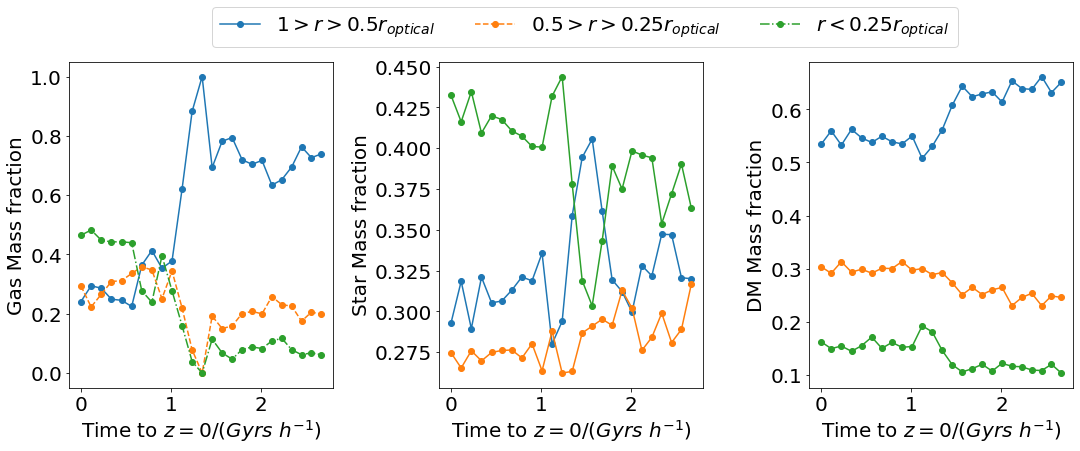

In [15]:
pl.figure(figsize=(18,6))

pl.subplots_adjust(wspace=0.4)

pl.subplot(1, 3, 1)

pl.plot(Time_4338, p1G_4338, marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4338, p5G_4338, marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4338, p25G_4338, marker='o', ls='-.', label='$r < 0.25 r_{optical}$')

pl.legend(ncol=3, bbox_to_anchor=(3.4,1.2))

pl.ylabel('Gas Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 2)

pl.plot(Time_4338, p1S_4338, marker='o', ls='-', label='Stars 1-0.5 $r_{optical}$')
pl.plot(Time_4338, p5S_4338, marker='o', ls='-', label='Stars 0.5-0.25 $r_{optical}$')
pl.plot(Time_4338, p25S_4338, marker='o', ls='-', label='Stars < 0.25 $r_{optical}$')

pl.ylabel('Star Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 3)

pl.plot(Time_4338, p1DM_4338, marker='o', ls='-', label='DM 1-0.5 $r_{optical}$')
pl.plot(Time_4338, p5DM_4338, marker='o', ls='-', label='DM 0.5-0.25 $r_{optical}$')
pl.plot(Time_4338, p25DM_4338, marker='o', ls='-', label='DM < 0.25 $r_{optical}$')

pl.ylabel('DM Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

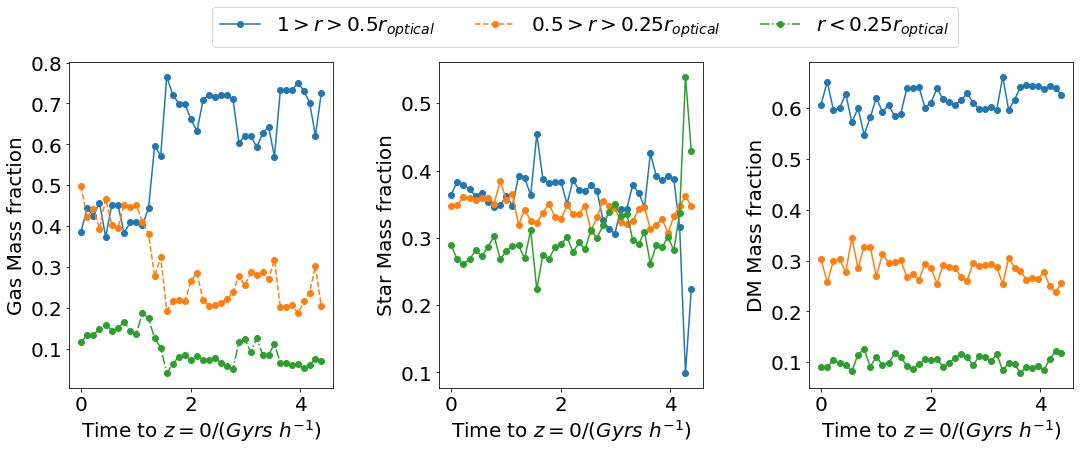

In [16]:
pl.figure(figsize=(18,6))

pl.subplots_adjust(wspace=0.4)

pl.subplot(1, 3, 1)

pl.plot(Time_4339, p1G_4339, marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4339, p5G_4339, marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4339, p25G_4339, marker='o', ls='-.', label='$r < 0.25 r_{optical}$')

pl.legend(ncol=3, bbox_to_anchor=(3.4,1.2))

pl.ylabel('Gas Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 2)

pl.plot(Time_4339, p1S_4339, marker='o', ls='-', label='Stars 1-0.5 $r_{optical}$')
pl.plot(Time_4339, p5S_4339, marker='o', ls='-', label='Stars 0.5-0.25 $r_{optical}$')
pl.plot(Time_4339, p25S_4339, marker='o', ls='-', label='Stars < 0.25 $r_{optical}$')

pl.ylabel('Star Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 3)

pl.plot(Time_4339, p1DM_4339, marker='o', ls='-', label='DM 1-0.5 $r_{optical}$')
pl.plot(Time_4339, p5DM_4339, marker='o', ls='-', label='DM 0.5-0.25 $r_{optical}$')
pl.plot(Time_4339, p25DM_4339, marker='o', ls='-', label='DM < 0.25 $r_{optical}$')

pl.ylabel('DM Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

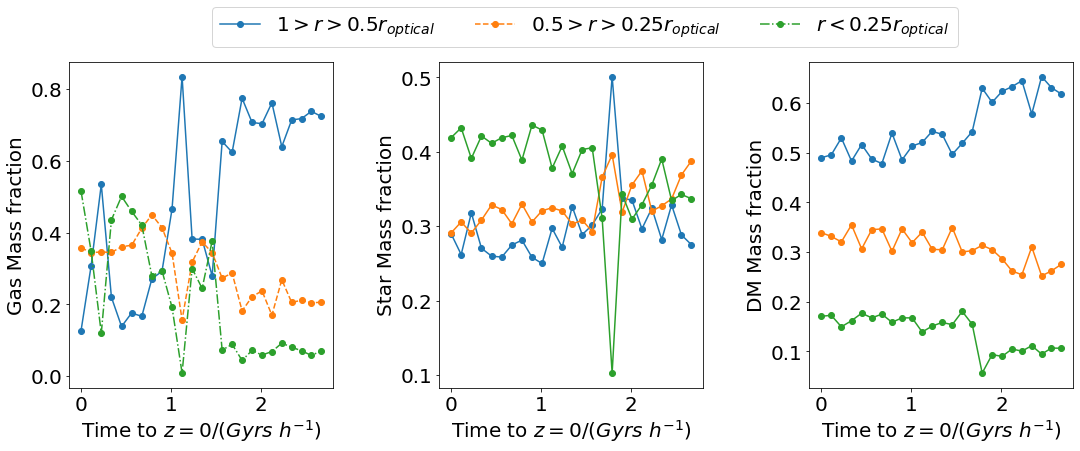

In [17]:
pl.figure(figsize=(18,6))

pl.subplots_adjust(wspace=0.4)

pl.subplot(1, 3, 1)

pl.plot(Time_4341, p1G_4341, marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4341, p5G_4341, marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4341, p25G_4341, marker='o', ls='-.', label='$r < 0.25 r_{optical}$')

pl.legend(ncol=3, bbox_to_anchor=(3.4,1.2))

pl.ylabel('Gas Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 2)

pl.plot(Time_4341, p1S_4341, marker='o', ls='-', label='Stars 1-0.5 $r_{optical}$')
pl.plot(Time_4341, p5S_4341, marker='o', ls='-', label='Stars 0.5-0.25 $r_{optical}$')
pl.plot(Time_4341, p25S_4341, marker='o', ls='-', label='Stars < 0.25 $r_{optical}$')

pl.ylabel('Star Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 3)

pl.plot(Time_4341, p1DM_4341, marker='o', ls='-', label='DM 1-0.5 $r_{optical}$')
pl.plot(Time_4341, p5DM_4341, marker='o', ls='-', label='DM 0.5-0.25 $r_{optical}$')
pl.plot(Time_4341, p25DM_4341, marker='o', ls='-', label='DM < 0.25 $r_{optical}$')

pl.ylabel('DM Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

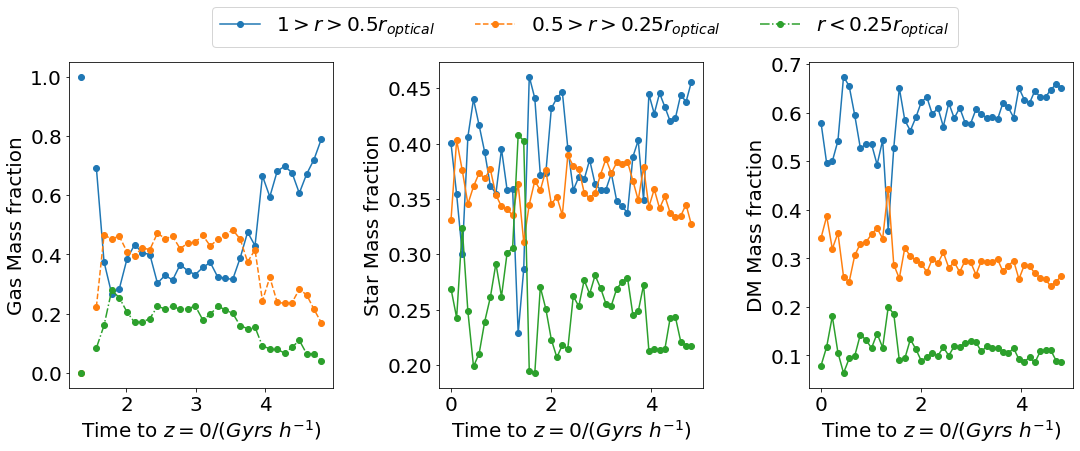

In [18]:
pl.figure(figsize=(18,6))

pl.subplots_adjust(wspace=0.4)

pl.subplot(1, 3, 1)

pl.plot(Time_4343, p1G_4343, marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4343, p5G_4343, marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4343, p25G_4343, marker='o', ls='-.', label='$r < 0.25 r_{optical}$')

pl.legend(ncol=3, bbox_to_anchor=(3.4,1.2))

pl.ylabel('Gas Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 2)

pl.plot(Time_4343, p1S_4343, marker='o', ls='-', label='Stars 1-0.5 $r_{optical}$')
pl.plot(Time_4343, p5S_4343, marker='o', ls='-', label='Stars 0.5-0.25 $r_{optical}$')
pl.plot(Time_4343, p25S_4343, marker='o', ls='-', label='Stars < 0.25 $r_{optical}$')

pl.ylabel('Star Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 3)

pl.plot(Time_4343, p1DM_4343, marker='o', ls='-', label='DM 1-0.5 $r_{optical}$')
pl.plot(Time_4343, p5DM_4343, marker='o', ls='-', label='DM 0.5-0.25 $r_{optical}$')
pl.plot(Time_4343, p25DM_4343, marker='o', ls='-', label='DM < 0.25 $r_{optical}$')

pl.ylabel('DM Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

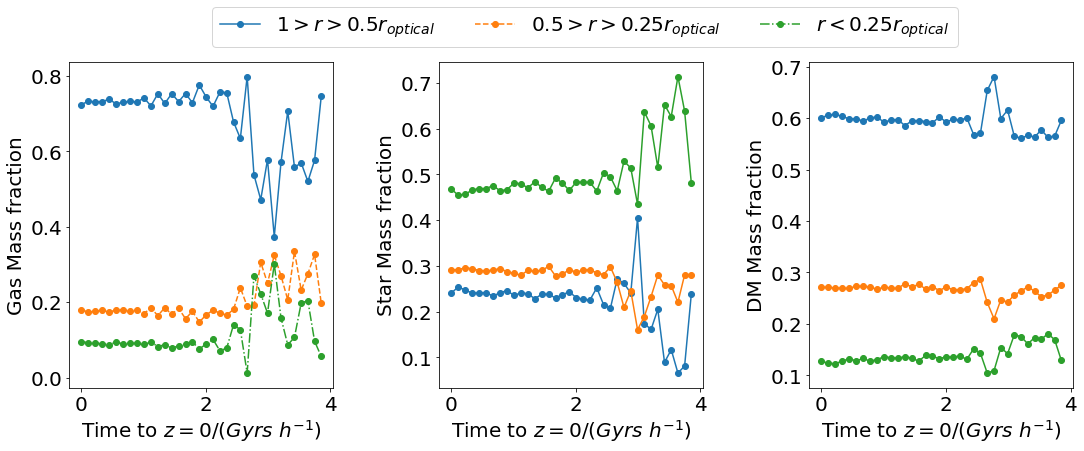

In [19]:
pl.figure(figsize=(18,6))

pl.subplots_adjust(wspace=0.4)

pl.subplot(1, 3, 1)

pl.plot(Time_4470, p1G_4470, marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4470, p5G_4470, marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4470, p25G_4470, marker='o', ls='-.', label='$r < 0.25 r_{optical}$')

pl.legend(ncol=3, bbox_to_anchor=(3.4,1.2))

pl.ylabel('Gas Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 2)

pl.plot(Time_4470, p1S_4470, marker='o', ls='-', label='Stars 1-0.5 $r_{optical}$')
pl.plot(Time_4470, p5S_4470, marker='o', ls='-', label='Stars 0.5-0.25 $r_{optical}$')
pl.plot(Time_4470, p25S_4470, marker='o', ls='-', label='Stars < 0.25 $r_{optical}$')

pl.ylabel('Star Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 3)

pl.plot(Time_4470, p1DM_4470, marker='o', ls='-', label='DM 1-0.5 $r_{optical}$')
pl.plot(Time_4470, p5DM_4470, marker='o', ls='-', label='DM 0.5-0.25 $r_{optical}$')
pl.plot(Time_4470, p25DM_4470, marker='o', ls='-', label='DM < 0.25 $r_{optical}$')

pl.ylabel('DM Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

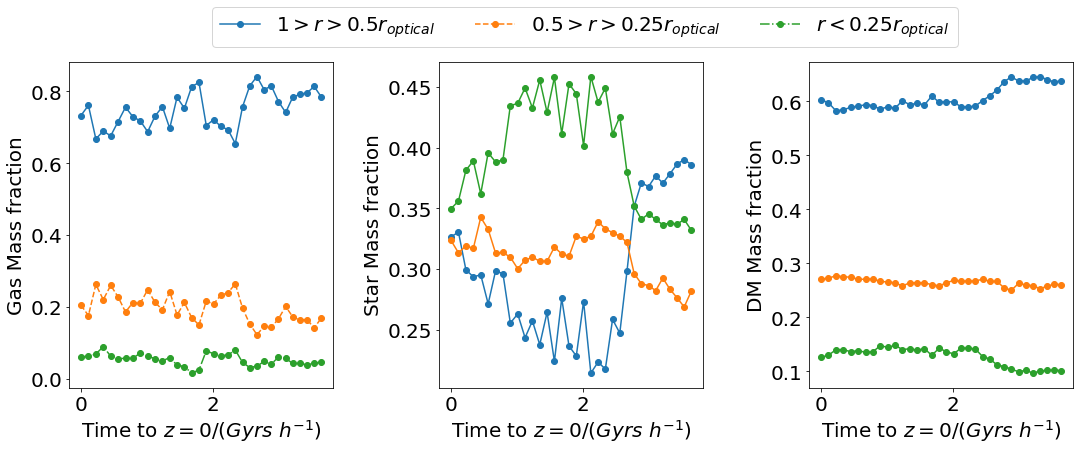

In [20]:
pl.figure(figsize=(18,6))

pl.subplots_adjust(wspace=0.4)

pl.subplot(1, 3, 1)

pl.plot(Time_4471, p1G_4471, marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4471, p5G_4471, marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4471, p25G_4471, marker='o', ls='-.', label='$r < 0.25 r_{optical}$')

pl.legend(ncol=3, bbox_to_anchor=(3.4,1.2))

pl.ylabel('Gas Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 2)

pl.plot(Time_4471, p1S_4471, marker='o', ls='-', label='Stars 1-0.5 $r_{optical}$')
pl.plot(Time_4471, p5S_4471, marker='o', ls='-', label='Stars 0.5-0.25 $r_{optical}$')
pl.plot(Time_4471, p25S_4471, marker='o', ls='-', label='Stars < 0.25 $r_{optical}$')

pl.ylabel('Star Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 3)

pl.plot(Time_4471, p1DM_4471, marker='o', ls='-', label='DM 1-0.5 $r_{optical}$')
pl.plot(Time_4471, p5DM_4471, marker='o', ls='-', label='DM 0.5-0.25 $r_{optical}$')
pl.plot(Time_4471, p25DM_4471, marker='o', ls='-', label='DM < 0.25 $r_{optical}$')

pl.ylabel('DM Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

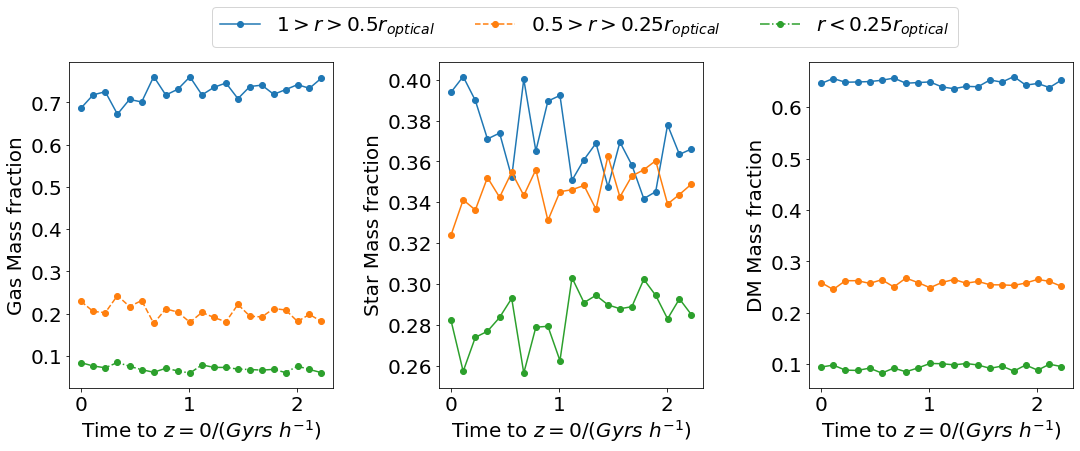

In [21]:
pl.figure(figsize=(18,6))

pl.subplots_adjust(wspace=0.4)

pl.subplot(1, 3, 1)

pl.plot(Time_4473, p1G_4473, marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4473, p5G_4473, marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4473, p25G_4473, marker='o', ls='-.', label='$r < 0.25 r_{optical}$')

pl.legend(ncol=3, bbox_to_anchor=(3.4,1.2))

pl.ylabel('Gas Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 2)

pl.plot(Time_4473, p1S_4473, marker='o', ls='-', label='Stars 1-0.5 $r_{optical}$')
pl.plot(Time_4473, p5S_4473, marker='o', ls='-', label='Stars 0.5-0.25 $r_{optical}$')
pl.plot(Time_4473, p25S_4473, marker='o', ls='-', label='Stars < 0.25 $r_{optical}$')

pl.ylabel('Star Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 3)

pl.plot(Time_4473, p1DM_4473, marker='o', ls='-', label='DM 1-0.5 $r_{optical}$')
pl.plot(Time_4473, p5DM_4473, marker='o', ls='-', label='DM 0.5-0.25 $r_{optical}$')
pl.plot(Time_4473, p25DM_4473, marker='o', ls='-', label='DM < 0.25 $r_{optical}$')

pl.ylabel('DM Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

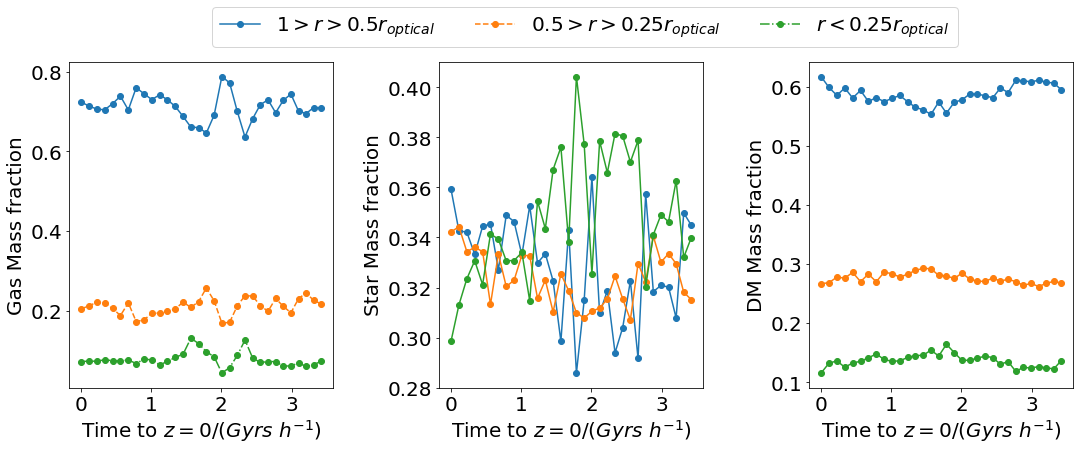

In [22]:
pl.figure(figsize=(18,6))

pl.subplots_adjust(wspace=0.4)

pl.subplot(1, 3, 1)

pl.plot(Time_4474, p1G_4474, marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4474, p5G_4474, marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4474, p25G_4474, marker='o', ls='-.', label='$r < 0.25 r_{optical}$')

pl.legend(ncol=3, bbox_to_anchor=(3.4,1.2))

pl.ylabel('Gas Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 2)

pl.plot(Time_4474, p1S_4474, marker='o', ls='-', label='Stars 1-0.5 $r_{optical}$')
pl.plot(Time_4474, p5S_4474, marker='o', ls='-', label='Stars 0.5-0.25 $r_{optical}$')
pl.plot(Time_4474, p25S_4474, marker='o', ls='-', label='Stars < 0.25 $r_{optical}$')

pl.ylabel('Star Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 3)

pl.plot(Time_4474, p1DM_4474, marker='o', ls='-', label='DM 1-0.5 $r_{optical}$')
pl.plot(Time_4474, p5DM_4474, marker='o', ls='-', label='DM 0.5-0.25 $r_{optical}$')
pl.plot(Time_4474, p25DM_4474, marker='o', ls='-', label='DM < 0.25 $r_{optical}$')

pl.ylabel('DM Mass fraction')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

In [23]:
# ok, i will take a look at the stars/gas ratio in different stages, even it is just in the interiors

rSG1_4338, rSG5_4338, rSG25_4338 = Mass1S_4338/Mass1G_4338, Mass5S_4338/Mass5G_4338, Mass25S_4338/Mass25G_4338
rSG1_4339, rSG5_4339, rSG25_4339 = Mass1S_4339/Mass1G_4339, Mass5S_4339/Mass5G_4339, Mass25S_4339/Mass25G_4339
rSG1_4341, rSG5_4341, rSG25_4341 = Mass1S_4341/Mass1G_4341, Mass5S_4341/Mass5G_4341, Mass25S_4341/Mass25G_4341
rSG1_4343, rSG5_4343, rSG25_4343 = Mass1S_4343/Mass1G_4343, Mass5S_4343/Mass5G_4343, Mass25S_4343/Mass25G_4343

rSG1_4470, rSG5_4470, rSG25_4470 = Mass1S_4470/Mass1G_4470, Mass5S_4470/Mass5G_4470, Mass25S_4470/Mass25G_4470
rSG1_4471, rSG5_4471, rSG25_4471 = Mass1S_4471/Mass1G_4471, Mass5S_4471/Mass5G_4471, Mass25S_4471/Mass25G_4471
rSG1_4473, rSG5_4473, rSG25_4473 = Mass1S_4473/Mass1G_4473, Mass5S_4473/Mass5G_4473, Mass25S_4473/Mass25G_4473
rSG1_4474, rSG5_4474, rSG25_4474 = Mass1S_4474/Mass1G_4474, Mass5S_4474/Mass5G_4474, Mass25S_4474/Mass25G_4474

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

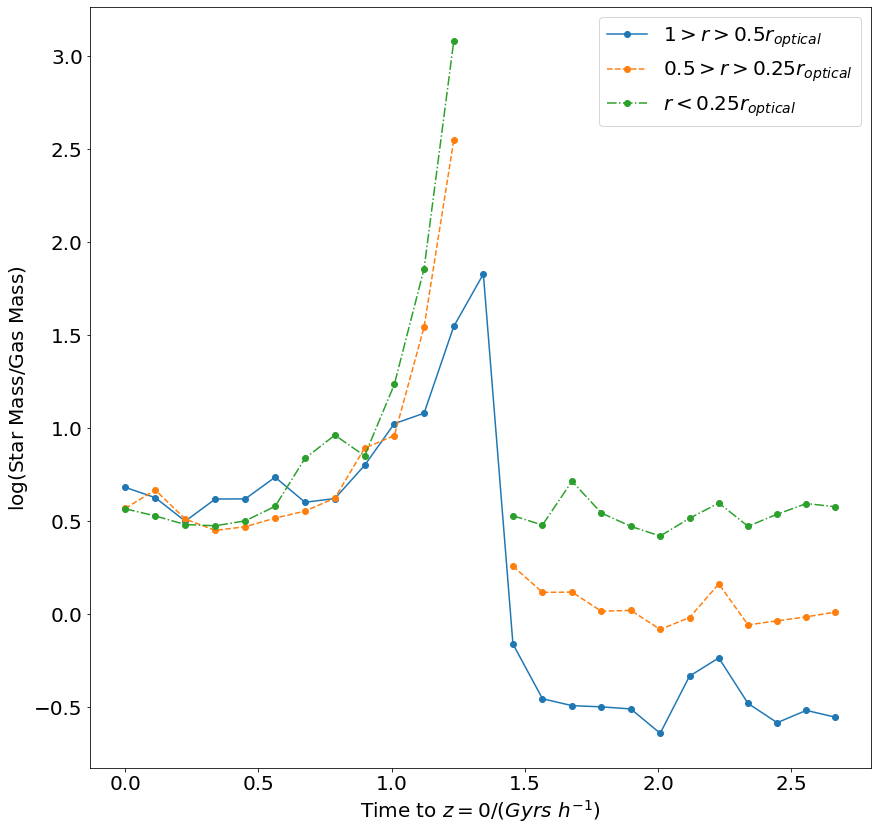

In [24]:
# ok, lets see some plots of this, and well, download the figures, if it came to that

pl.figure(figsize=(14,14))

pl.plot(Time_4338, np.log10(rSG1_4338), marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4338, np.log10(rSG5_4338), marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4338, np.log10(rSG25_4338), marker='o', ls='-.', label='$r<0.25 r_{optical}$')

pl.legend(loc='best')

pl.ylabel('$\log($Star Mass/Gas Mass)')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

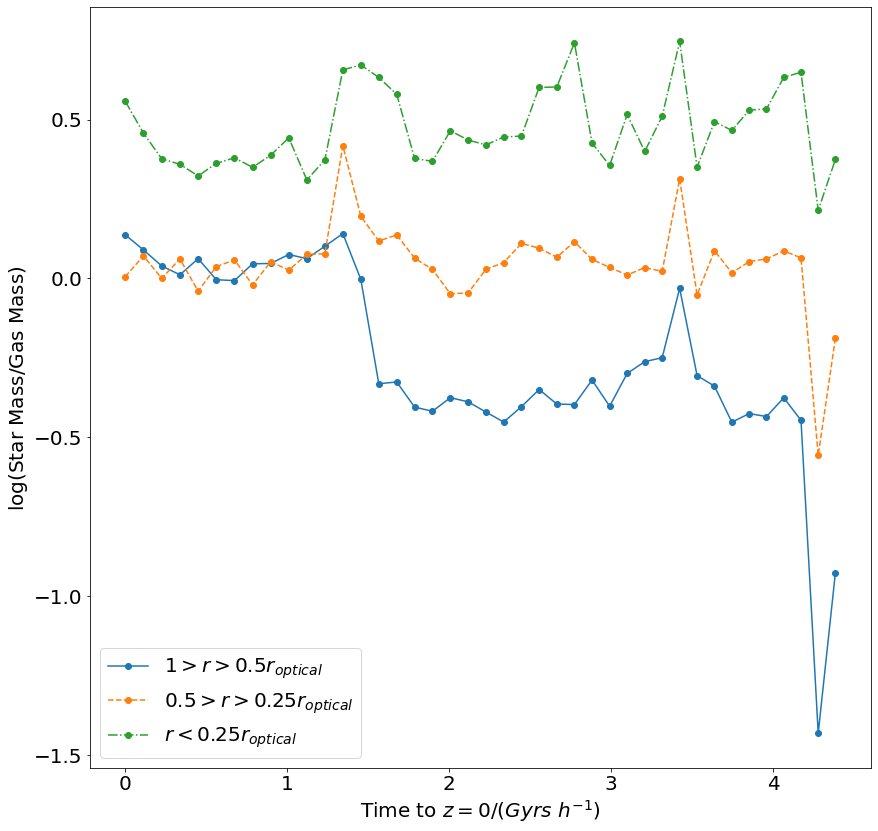

In [25]:
pl.figure(figsize=(14,14))

pl.plot(Time_4339, np.log10(rSG1_4339), marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4339, np.log10(rSG5_4339), marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4339, np.log10(rSG25_4339), marker='o', ls='-.', label='$r<0.25 r_{optical}$')

pl.legend(loc='best')

pl.ylabel('$\log($Star Mass/Gas Mass)')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

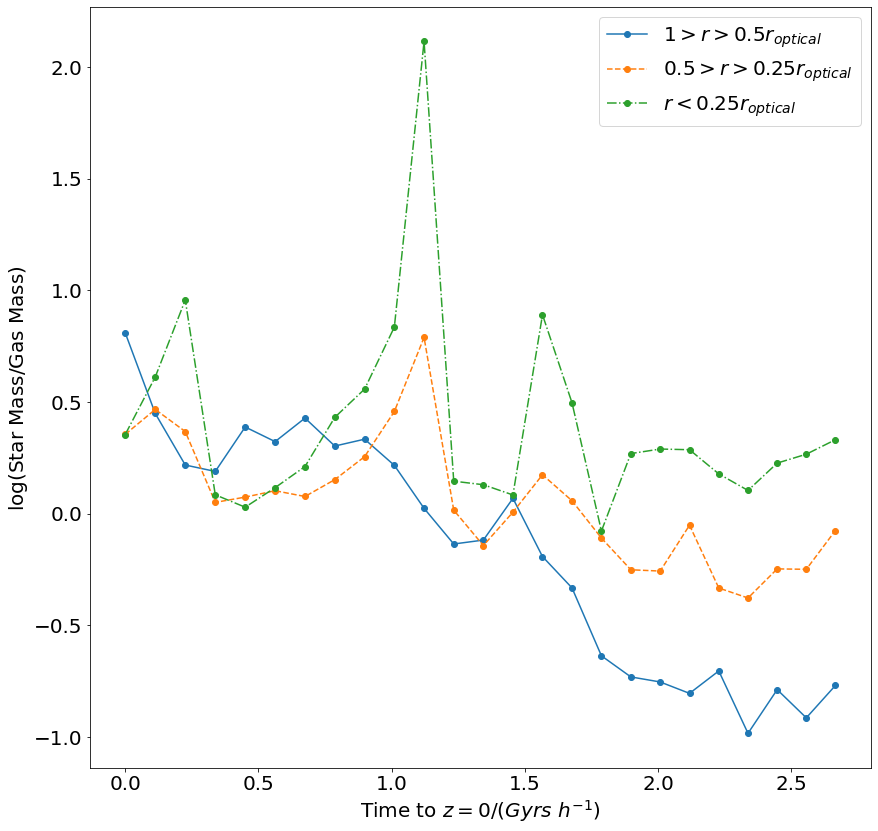

In [26]:
pl.figure(figsize=(14,14))

pl.plot(Time_4341, np.log10(rSG1_4341), marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4341, np.log10(rSG5_4341), marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4341, np.log10(rSG25_4341), marker='o', ls='-.', label='$r<0.25 r_{optical}$')

pl.legend(loc='best')

pl.ylabel('$\log($Star Mass/Gas Mass)')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

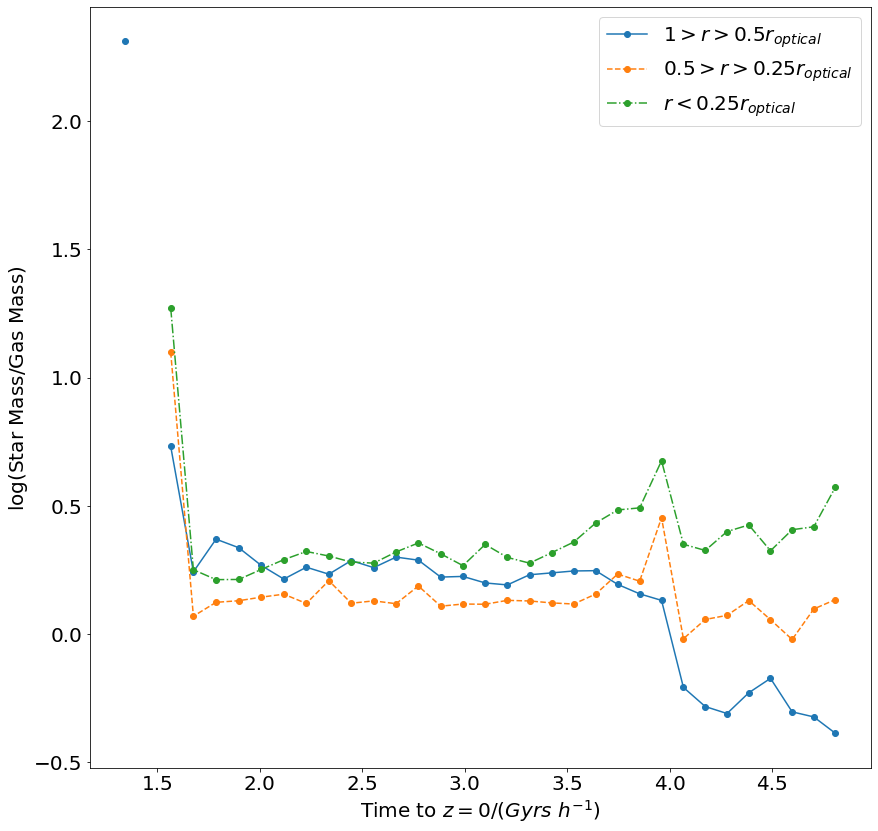

In [27]:
pl.figure(figsize=(14,14))

pl.plot(Time_4343, np.log10(rSG1_4343), marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4343, np.log10(rSG5_4343), marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4343, np.log10(rSG25_4343), marker='o', ls='-.', label='$r<0.25 r_{optical}$')

pl.legend(loc='best')

pl.ylabel('$\log($Star Mass/Gas Mass)')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

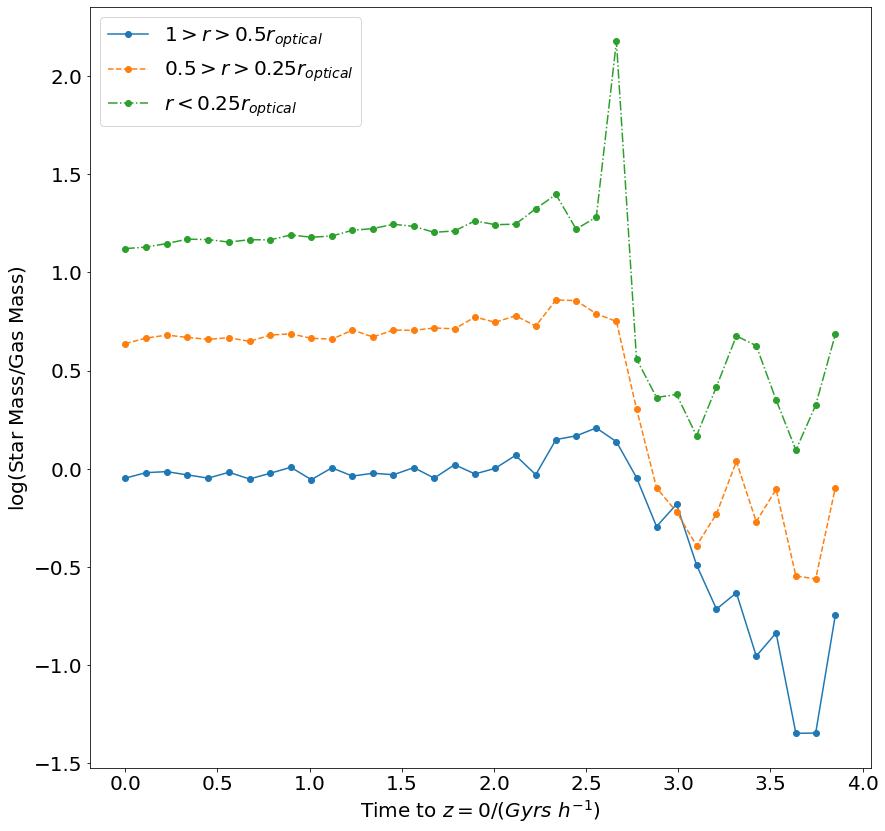

In [28]:
pl.figure(figsize=(14,14))

pl.plot(Time_4470, np.log10(rSG1_4470), marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4470, np.log10(rSG5_4470), marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4470, np.log10(rSG25_4470), marker='o', ls='-.', label='$r<0.25 r_{optical}$')

pl.legend(loc='best')

pl.ylabel('$\log($Star Mass/Gas Mass)')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

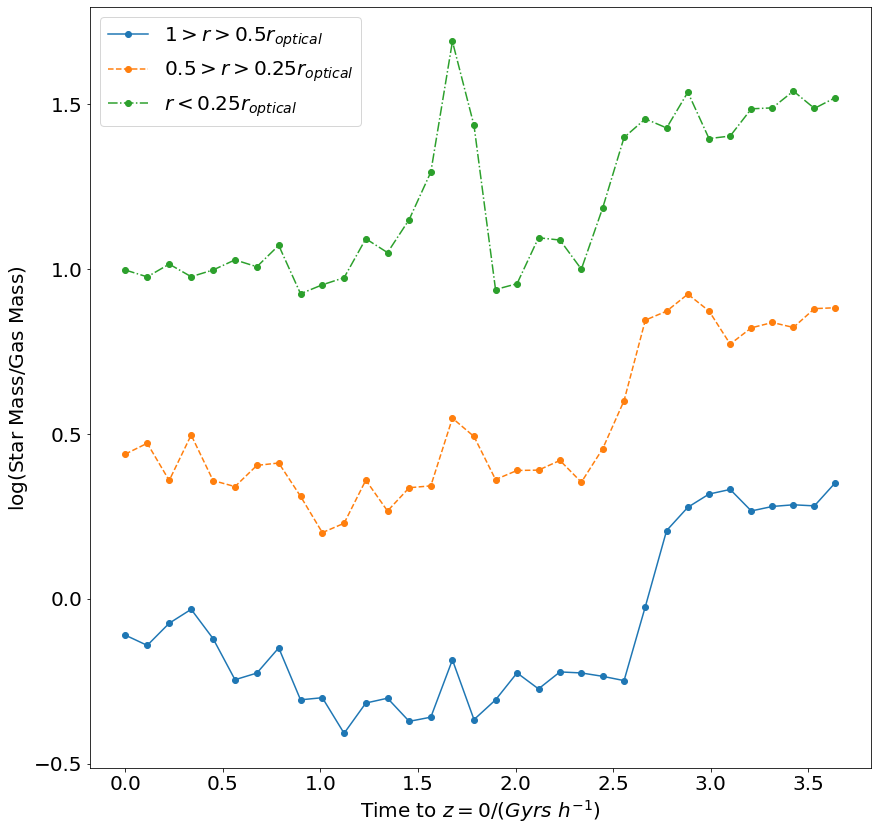

In [29]:
pl.figure(figsize=(14,14))

pl.plot(Time_4471, np.log10(rSG1_4471), marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4471, np.log10(rSG5_4471), marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4471, np.log10(rSG25_4471), marker='o', ls='-.', label='$r<0.25 r_{optical}$')

pl.legend(loc='best')

pl.ylabel('$\log($Star Mass/Gas Mass)')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

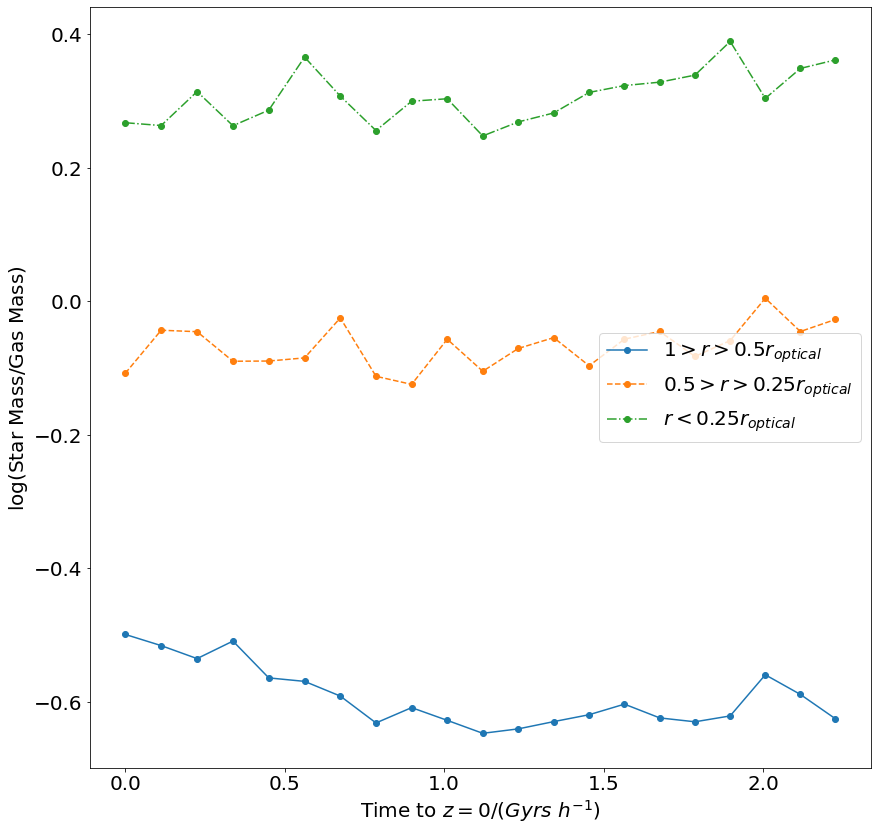

In [30]:
pl.figure(figsize=(14,14))

pl.plot(Time_4473, np.log10(rSG1_4473), marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4473, np.log10(rSG5_4473), marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4473, np.log10(rSG25_4473), marker='o', ls='-.', label='$r<0.25 r_{optical}$')

pl.legend(loc='best')

pl.ylabel('$\log($Star Mass/Gas Mass)')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

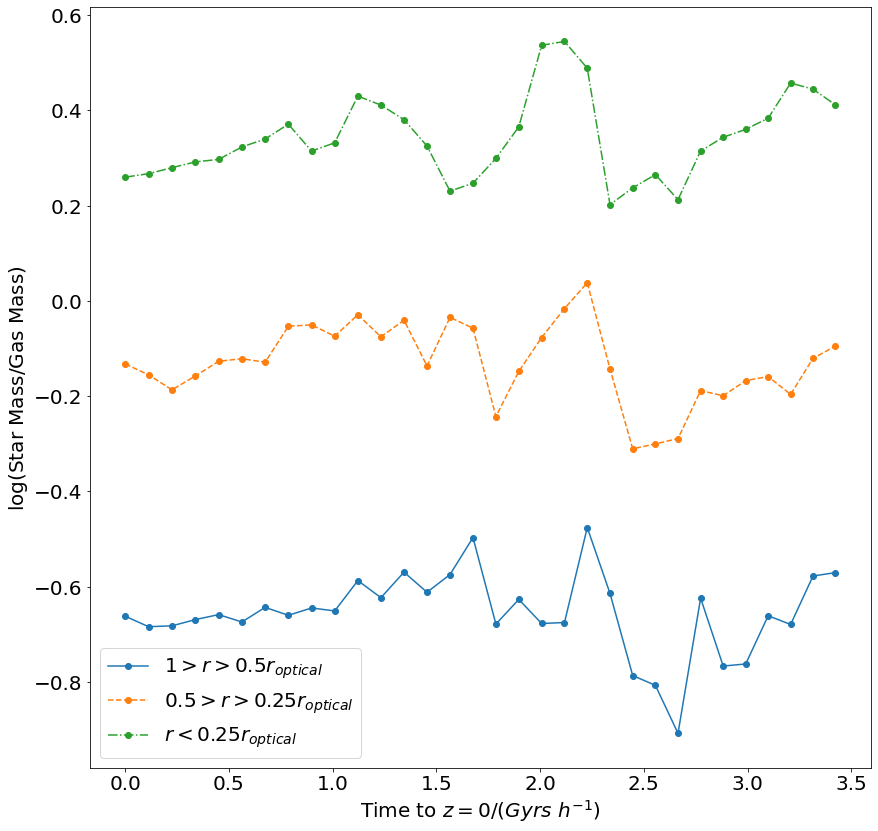

In [31]:
pl.figure(figsize=(14,14))

pl.plot(Time_4474, np.log10(rSG1_4474), marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4474, np.log10(rSG5_4474), marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4474, np.log10(rSG25_4474), marker='o', ls='-.', label='$r<0.25 r_{optical}$')

pl.legend(loc='best')

pl.ylabel('$\log($Star Mass/Gas Mass)')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

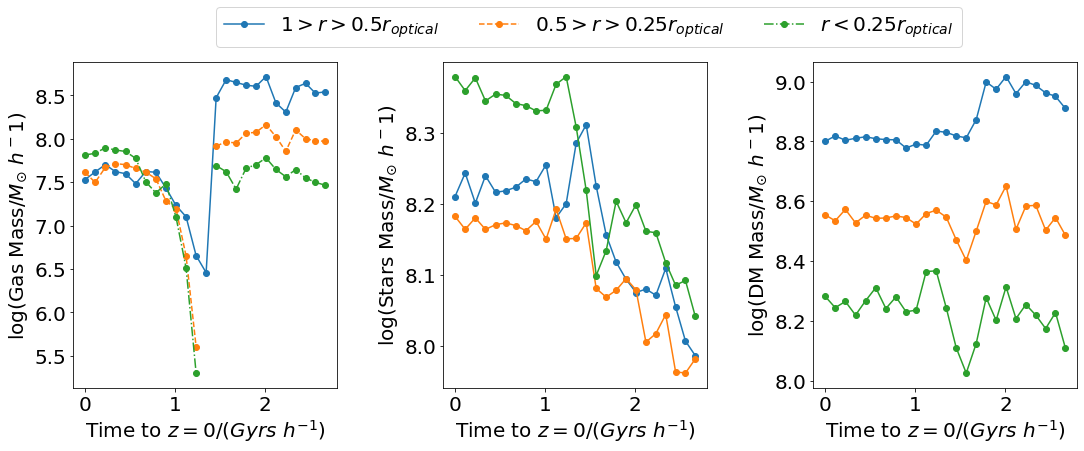

In [32]:
#and just the masses.
pl.figure(figsize=(18,6))

pl.subplots_adjust(wspace=0.4)

pl.subplot(1, 3, 1)

pl.plot(Time_4338, np.log10(Mass1G_4338), marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4338, np.log10(Mass5G_4338), marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4338, np.log10(Mass25G_4338), marker='o', ls='-.', label='$r < 0.25 r_{optical}$')

pl.legend(ncol=3, bbox_to_anchor=(3.4,1.2))

pl.ylabel('$\log($Gas Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 2)

pl.plot(Time_4338, np.log10(Mass1S_4338), marker='o', ls='-', label='Stars 1-0.5 $r_{optical}$')
pl.plot(Time_4338, np.log10(Mass5S_4338), marker='o', ls='-', label='Stars 0.5-0.25 $r_{optical}$')
pl.plot(Time_4338, np.log10(Mass25S_4338), marker='o', ls='-', label='Stars < 0.25 $r_{optical}$')

pl.ylabel('$\log($Stars Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 3)

pl.plot(Time_4338, np.log10(Mass1DM_4338), marker='o', ls='-', label='DM 1-0.5 $r_{optical}$')
pl.plot(Time_4338, np.log10(Mass5DM_4338), marker='o', ls='-', label='DM 0.5-0.25 $r_{optical}$')
pl.plot(Time_4338, np.log10(Mass25DM_4338), marker='o', ls='-', label='DM < 0.25 $r_{optical}$')

pl.ylabel('$\log($DM Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

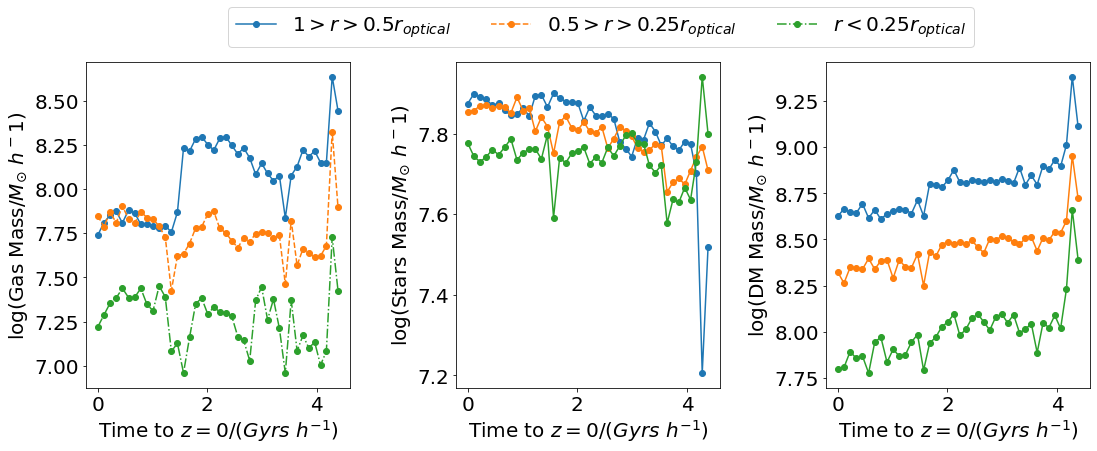

In [33]:

pl.figure(figsize=(18,6))

pl.subplots_adjust(wspace=0.4)

pl.subplot(1, 3, 1)

pl.plot(Time_4339, np.log10(Mass1G_4339), marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4339, np.log10(Mass5G_4339), marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4339, np.log10(Mass25G_4339), marker='o', ls='-.', label='$r < 0.25 r_{optical}$')

pl.legend(ncol=3, bbox_to_anchor=(3.4,1.2))

pl.ylabel('$\log($Gas Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 2)

pl.plot(Time_4339, np.log10(Mass1S_4339), marker='o', ls='-', label='Stars 1-0.5 $r_{optical}$')
pl.plot(Time_4339, np.log10(Mass5S_4339), marker='o', ls='-', label='Stars 0.5-0.25 $r_{optical}$')
pl.plot(Time_4339, np.log10(Mass25S_4339), marker='o', ls='-', label='Stars < 0.25 $r_{optical}$')

pl.ylabel('$\log($Stars Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 3)

pl.plot(Time_4339, np.log10(Mass1DM_4339), marker='o', ls='-', label='DM 1-0.5 $r_{optical}$')
pl.plot(Time_4339, np.log10(Mass5DM_4339), marker='o', ls='-', label='DM 0.5-0.25 $r_{optical}$')
pl.plot(Time_4339, np.log10(Mass25DM_4339), marker='o', ls='-', label='DM < 0.25 $r_{optical}$')

pl.ylabel('$\log($DM Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

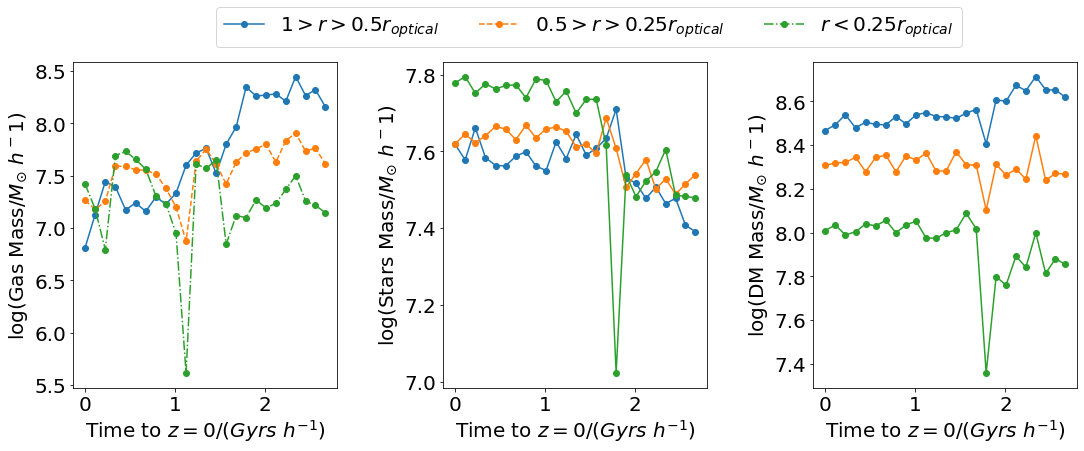

In [34]:

pl.figure(figsize=(18,6))

pl.subplots_adjust(wspace=0.4)

pl.subplot(1, 3, 1)

pl.plot(Time_4341, np.log10(Mass1G_4341), marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4341, np.log10(Mass5G_4341), marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4341, np.log10(Mass25G_4341), marker='o', ls='-.', label='$r < 0.25 r_{optical}$')

pl.legend(ncol=3, bbox_to_anchor=(3.4,1.2))

pl.ylabel('$\log($Gas Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 2)

pl.plot(Time_4341, np.log10(Mass1S_4341), marker='o', ls='-', label='Stars 1-0.5 $r_{optical}$')
pl.plot(Time_4341, np.log10(Mass5S_4341), marker='o', ls='-', label='Stars 0.5-0.25 $r_{optical}$')
pl.plot(Time_4341, np.log10(Mass25S_4341), marker='o', ls='-', label='Stars < 0.25 $r_{optical}$')

pl.ylabel('$\log($Stars Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 3)

pl.plot(Time_4341, np.log10(Mass1DM_4341), marker='o', ls='-', label='DM 1-0.5 $r_{optical}$')
pl.plot(Time_4341, np.log10(Mass5DM_4341), marker='o', ls='-', label='DM 0.5-0.25 $r_{optical}$')
pl.plot(Time_4341, np.log10(Mass25DM_4341), marker='o', ls='-', label='DM < 0.25 $r_{optical}$')

pl.ylabel('$\log($DM Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

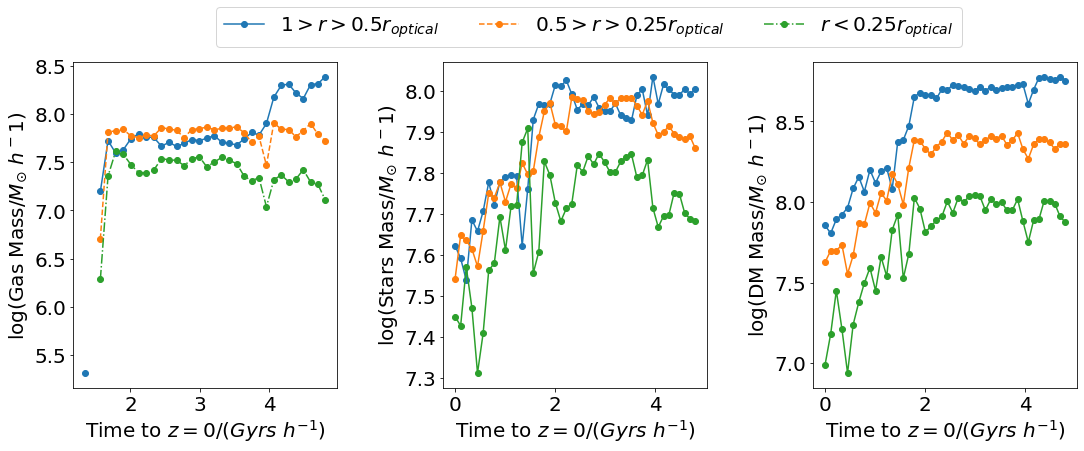

In [35]:

pl.figure(figsize=(18,6))

pl.subplots_adjust(wspace=0.4)

pl.subplot(1, 3, 1)

pl.plot(Time_4343, np.log10(Mass1G_4343), marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4343, np.log10(Mass5G_4343), marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4343, np.log10(Mass25G_4343), marker='o', ls='-.', label='$r < 0.25 r_{optical}$')

pl.legend(ncol=3, bbox_to_anchor=(3.4,1.2))

pl.ylabel('$\log($Gas Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 2)

pl.plot(Time_4343, np.log10(Mass1S_4343), marker='o', ls='-', label='Stars 1-0.5 $r_{optical}$')
pl.plot(Time_4343, np.log10(Mass5S_4343), marker='o', ls='-', label='Stars 0.5-0.25 $r_{optical}$')
pl.plot(Time_4343, np.log10(Mass25S_4343), marker='o', ls='-', label='Stars < 0.25 $r_{optical}$')

pl.ylabel('$\log($Stars Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 3)

pl.plot(Time_4343, np.log10(Mass1DM_4343), marker='o', ls='-', label='DM 1-0.5 $r_{optical}$')
pl.plot(Time_4343, np.log10(Mass5DM_4343), marker='o', ls='-', label='DM 0.5-0.25 $r_{optical}$')
pl.plot(Time_4343, np.log10(Mass25DM_4343), marker='o', ls='-', label='DM < 0.25 $r_{optical}$')

pl.ylabel('$\log($DM Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

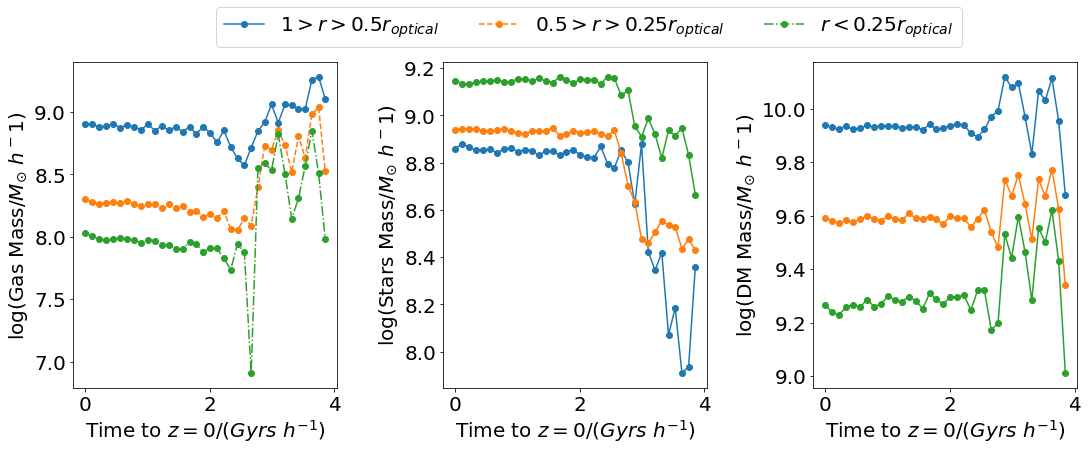

In [36]:

pl.figure(figsize=(18,6))

pl.subplots_adjust(wspace=0.4)

pl.subplot(1, 3, 1)

pl.plot(Time_4470, np.log10(Mass1G_4470), marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4470, np.log10(Mass5G_4470), marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4470, np.log10(Mass25G_4470), marker='o', ls='-.', label='$r < 0.25 r_{optical}$')

pl.legend(ncol=3, bbox_to_anchor=(3.4,1.2))

pl.ylabel('$\log($Gas Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 2)

pl.plot(Time_4470, np.log10(Mass1S_4470), marker='o', ls='-', label='Stars 1-0.5 $r_{optical}$')
pl.plot(Time_4470, np.log10(Mass5S_4470), marker='o', ls='-', label='Stars 0.5-0.25 $r_{optical}$')
pl.plot(Time_4470, np.log10(Mass25S_4470), marker='o', ls='-', label='Stars < 0.25 $r_{optical}$')

pl.ylabel('$\log($Stars Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 3)

pl.plot(Time_4470, np.log10(Mass1DM_4470), marker='o', ls='-', label='DM 1-0.5 $r_{optical}$')
pl.plot(Time_4470, np.log10(Mass5DM_4470), marker='o', ls='-', label='DM 0.5-0.25 $r_{optical}$')
pl.plot(Time_4470, np.log10(Mass25DM_4470), marker='o', ls='-', label='DM < 0.25 $r_{optical}$')

pl.ylabel('$\log($DM Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

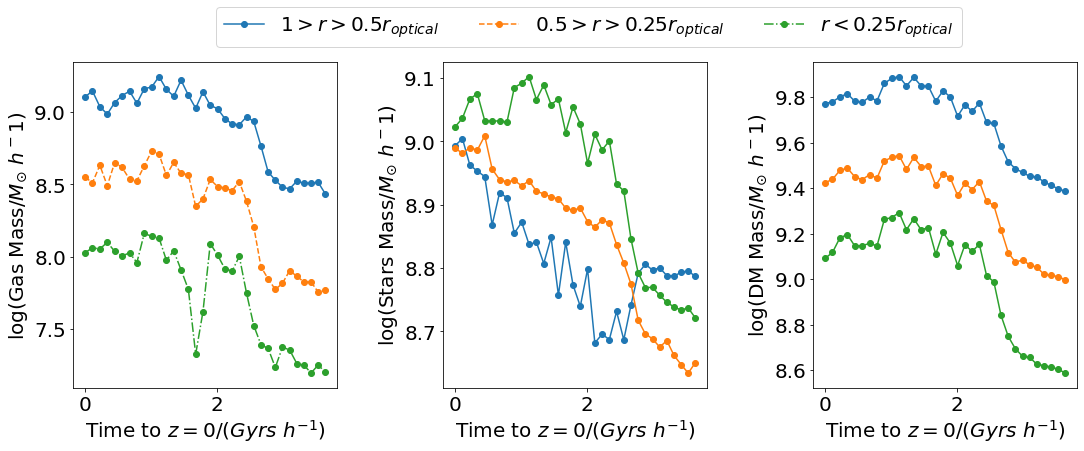

In [37]:

pl.figure(figsize=(18,6))

pl.subplots_adjust(wspace=0.4)

pl.subplot(1, 3, 1)

pl.plot(Time_4471, np.log10(Mass1G_4471), marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4471, np.log10(Mass5G_4471), marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4471, np.log10(Mass25G_4471), marker='o', ls='-.', label='$r < 0.25 r_{optical}$')

pl.legend(ncol=3, bbox_to_anchor=(3.4,1.2))

pl.ylabel('$\log($Gas Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 2)

pl.plot(Time_4471, np.log10(Mass1S_4471), marker='o', ls='-', label='Stars 1-0.5 $r_{optical}$')
pl.plot(Time_4471, np.log10(Mass5S_4471), marker='o', ls='-', label='Stars 0.5-0.25 $r_{optical}$')
pl.plot(Time_4471, np.log10(Mass25S_4471), marker='o', ls='-', label='Stars < 0.25 $r_{optical}$')

pl.ylabel('$\log($Stars Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 3)

pl.plot(Time_4471, np.log10(Mass1DM_4471), marker='o', ls='-', label='DM 1-0.5 $r_{optical}$')
pl.plot(Time_4471, np.log10(Mass5DM_4471), marker='o', ls='-', label='DM 0.5-0.25 $r_{optical}$')
pl.plot(Time_4471, np.log10(Mass25DM_4471), marker='o', ls='-', label='DM < 0.25 $r_{optical}$')

pl.ylabel('$\log($DM Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

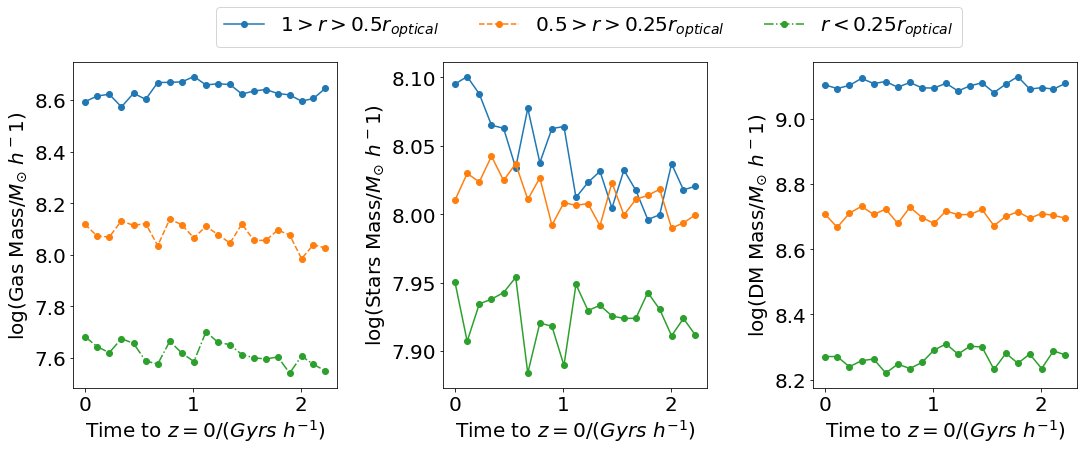

In [38]:

pl.figure(figsize=(18,6))

pl.subplots_adjust(wspace=0.4)

pl.subplot(1, 3, 1)

pl.plot(Time_4473, np.log10(Mass1G_4473), marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4473, np.log10(Mass5G_4473), marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4473, np.log10(Mass25G_4473), marker='o', ls='-.', label='$r < 0.25 r_{optical}$')

pl.legend(ncol=3, bbox_to_anchor=(3.4,1.2))

pl.ylabel('$\log($Gas Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 2)

pl.plot(Time_4473, np.log10(Mass1S_4473), marker='o', ls='-', label='Stars 1-0.5 $r_{optical}$')
pl.plot(Time_4473, np.log10(Mass5S_4473), marker='o', ls='-', label='Stars 0.5-0.25 $r_{optical}$')
pl.plot(Time_4473, np.log10(Mass25S_4473), marker='o', ls='-', label='Stars < 0.25 $r_{optical}$')

pl.ylabel('$\log($Stars Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 3)

pl.plot(Time_4473, np.log10(Mass1DM_4473), marker='o', ls='-', label='DM 1-0.5 $r_{optical}$')
pl.plot(Time_4473, np.log10(Mass5DM_4473), marker='o', ls='-', label='DM 0.5-0.25 $r_{optical}$')
pl.plot(Time_4473, np.log10(Mass25DM_4473), marker='o', ls='-', label='DM < 0.25 $r_{optical}$')

pl.ylabel('$\log($DM Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

Text(0.5, 0, 'Time to $z=0 /(Gyrs\\,\\,h^{-1})$')

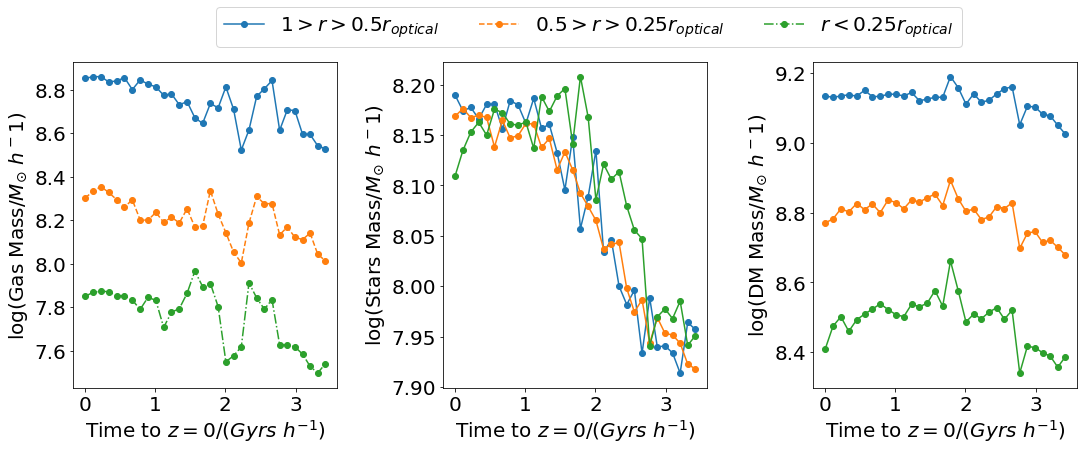

In [39]:

pl.figure(figsize=(18,6))

pl.subplots_adjust(wspace=0.4)

pl.subplot(1, 3, 1)

pl.plot(Time_4474, np.log10(Mass1G_4474), marker='o', ls='-', label='$1>r>0.5 r_{optical}$')
pl.plot(Time_4474, np.log10(Mass5G_4474), marker='o', ls='--', label='$0.5>r>0.25 r_{optical}$')
pl.plot(Time_4474, np.log10(Mass25G_4474), marker='o', ls='-.', label='$r < 0.25 r_{optical}$')

pl.legend(ncol=3, bbox_to_anchor=(3.4,1.2))

pl.ylabel('$\log($Gas Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 2)

pl.plot(Time_4474, np.log10(Mass1S_4474), marker='o', ls='-', label='Stars 1-0.5 $r_{optical}$')
pl.plot(Time_4474, np.log10(Mass5S_4474), marker='o', ls='-', label='Stars 0.5-0.25 $r_{optical}$')
pl.plot(Time_4474, np.log10(Mass25S_4474), marker='o', ls='-', label='Stars < 0.25 $r_{optical}$')

pl.ylabel('$\log($Stars Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

pl.subplot(1, 3, 3)

pl.plot(Time_4474, np.log10(Mass1DM_4474), marker='o', ls='-', label='DM 1-0.5 $r_{optical}$')
pl.plot(Time_4474, np.log10(Mass5DM_4474), marker='o', ls='-', label='DM 0.5-0.25 $r_{optical}$')
pl.plot(Time_4474, np.log10(Mass25DM_4474), marker='o', ls='-', label='DM < 0.25 $r_{optical}$')

pl.ylabel('$\log($DM Mass$/M_{\odot}\,\,h^-1)$')
pl.xlabel('Time to $z=0 /(Gyrs\,\,h^{-1})$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

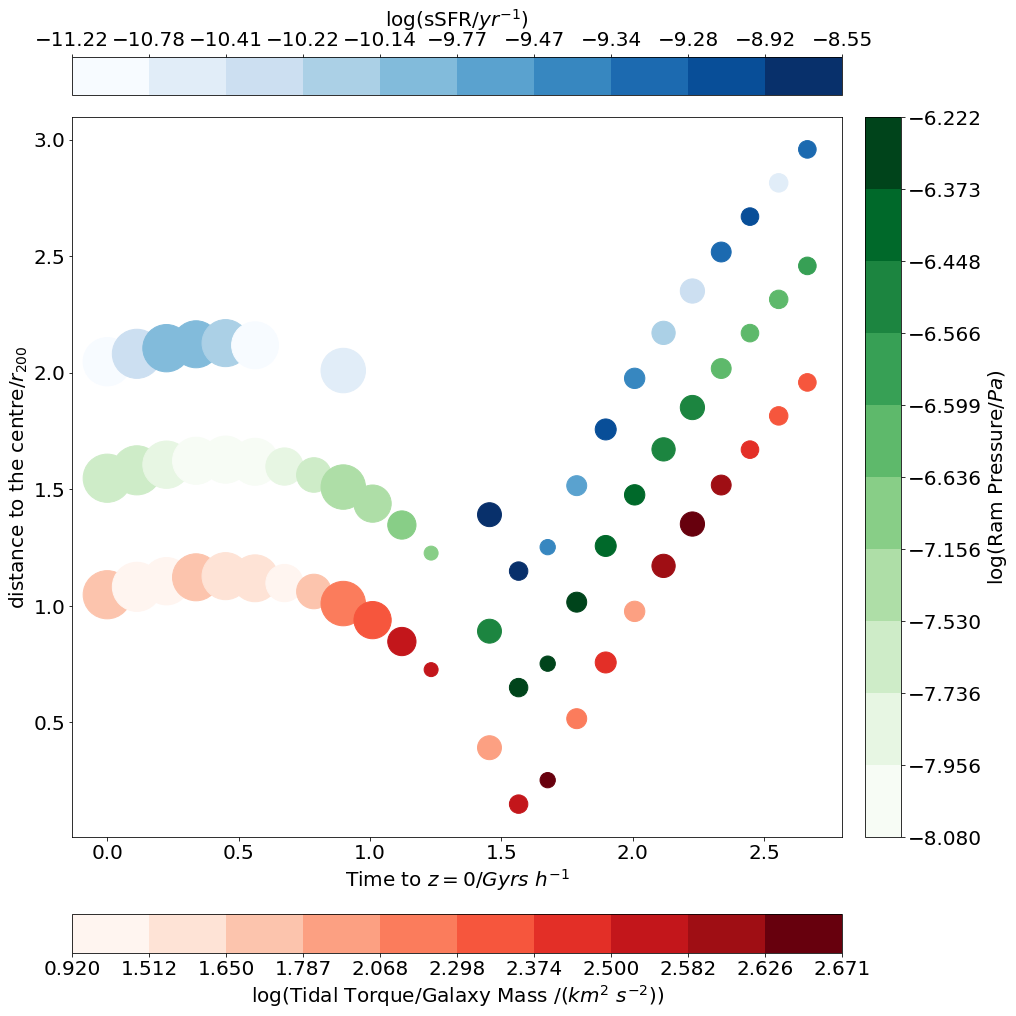

In [40]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4338/gMass_4338), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4338, dist_4338, s=p25G_4338*5000, c=np.log10(TSt_4338/gMass_4338), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4338), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4338, dist_4338+0.5, s=p25G_4338*5000, c=np.log10(RP_4338), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4338/starMass_4338)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4338, dist_4338+1., s=p25G_4338*5000, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

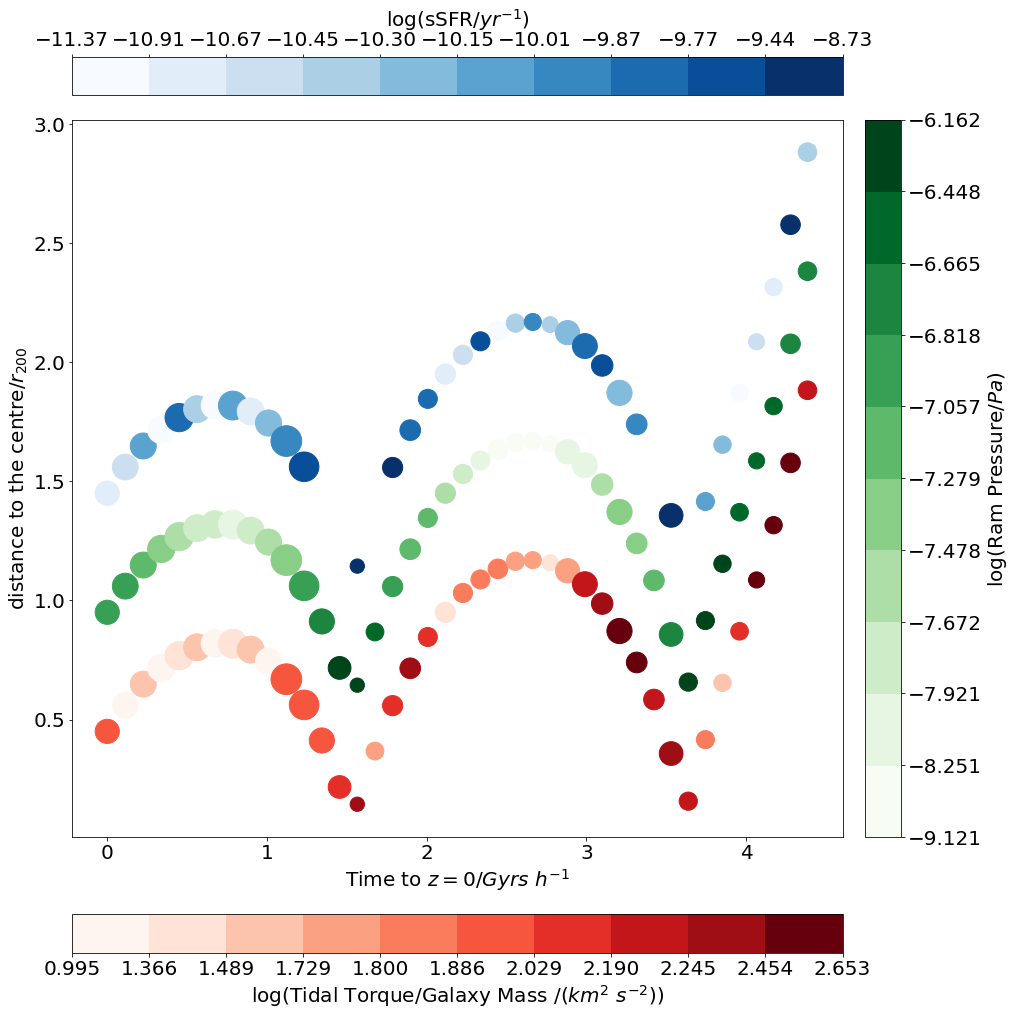

In [41]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4339/gMass_4339), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4339, dist_4339, s=p25G_4339*5000, c=np.log10(TSt_4339/gMass_4339), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4339), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4339, dist_4339+0.5, s=p25G_4339*5000, c=np.log10(RP_4339), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4339/starMass_4339)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4339, dist_4339+1., s=p25G_4339*5000, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

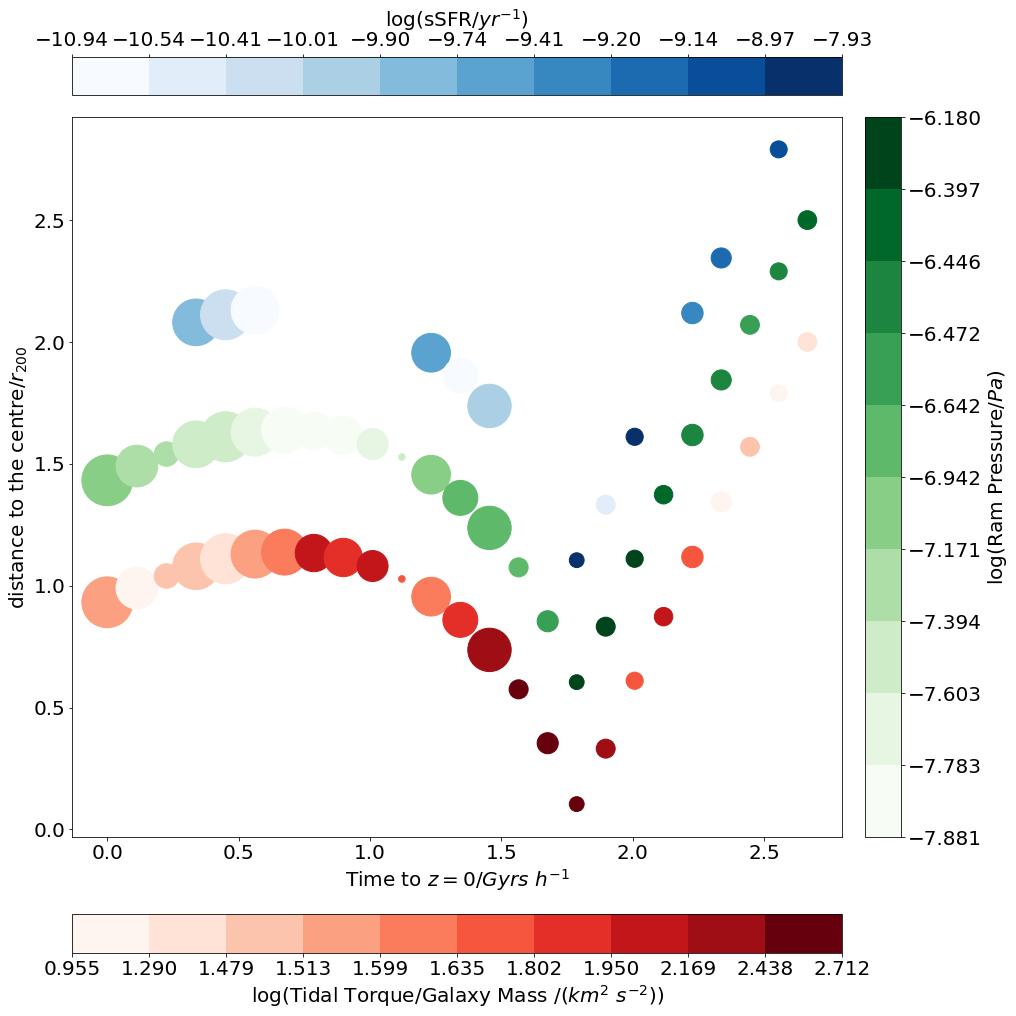

In [42]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4341/gMass_4341), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4341, dist_4341, s=p25G_4341*5000, c=np.log10(TSt_4341/gMass_4341), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4341), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4341, dist_4341+0.5, s=p25G_4341*5000, c=np.log10(RP_4341), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4341/starMass_4341)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4341, dist_4341+1., s=p25G_4341*5000, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

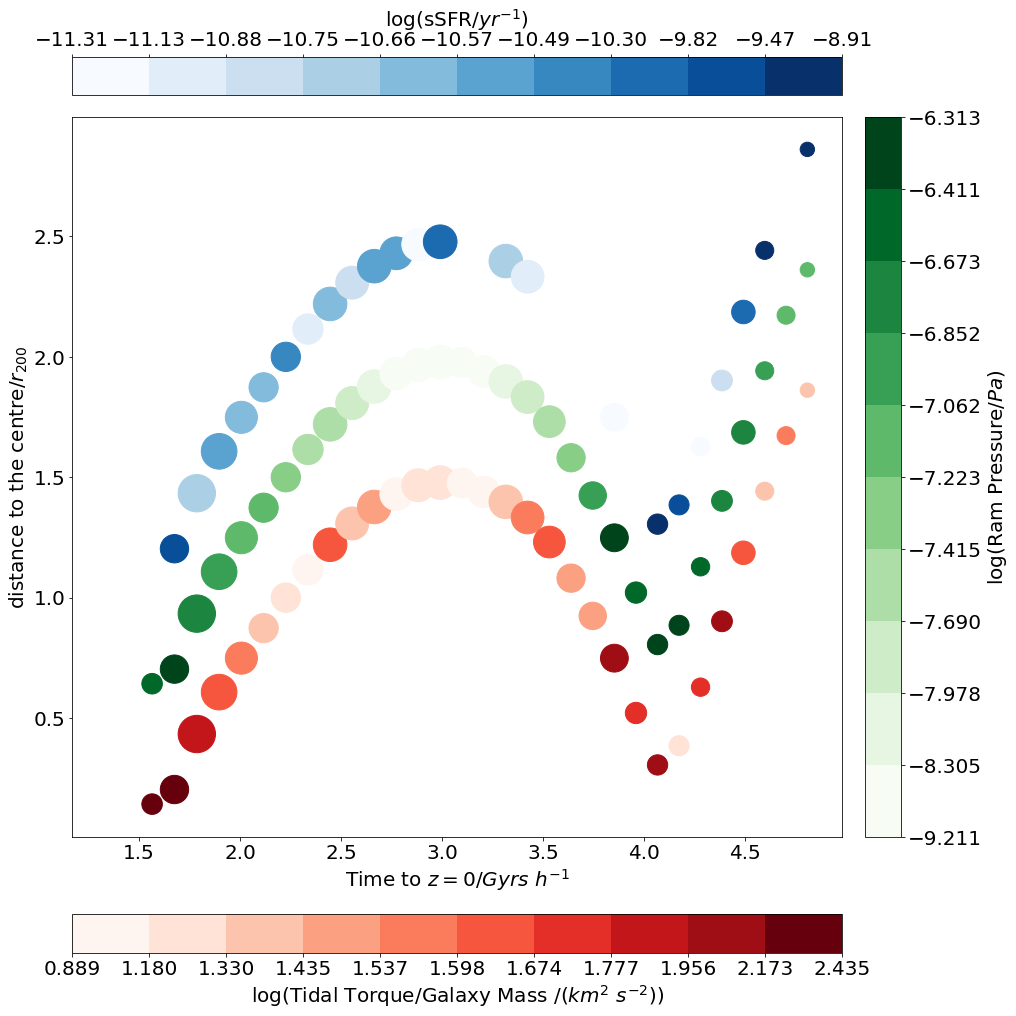

In [43]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4343/gMass_4343), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4343, dist_4343, s=p25G_4343*5000, c=np.log10(TSt_4343/gMass_4343), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4343), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4343, dist_4343+0.5, s=p25G_4343*5000, c=np.log10(RP_4343), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4343/starMass_4343)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4343, dist_4343+1., s=p25G_4343*5000, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

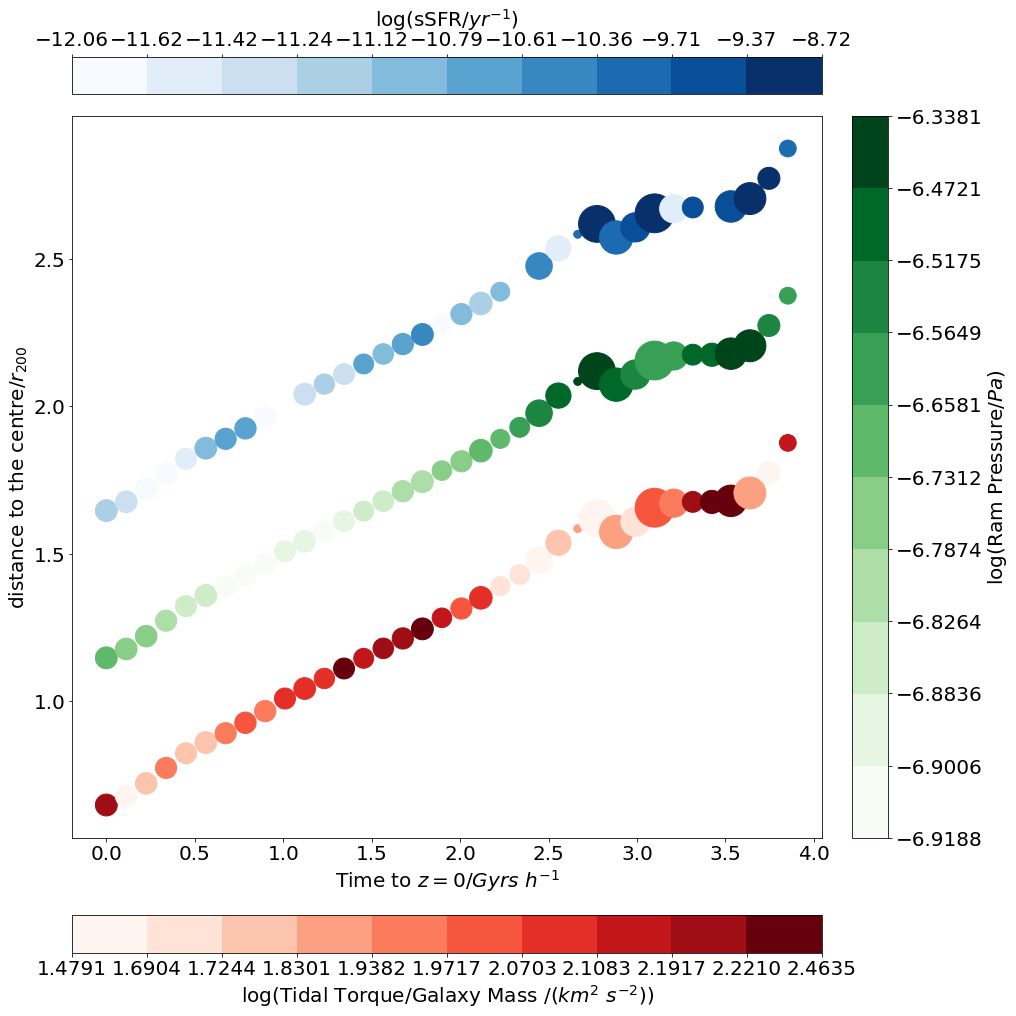

In [44]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4470/gMass_4470), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4470, dist_4470, s=p25G_4470*5000, c=np.log10(TSt_4470/gMass_4470), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4470), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4470, dist_4470+0.5, s=p25G_4470*5000, c=np.log10(RP_4470), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4470/starMass_4470)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4470, dist_4470+1., s=p25G_4470*5000, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

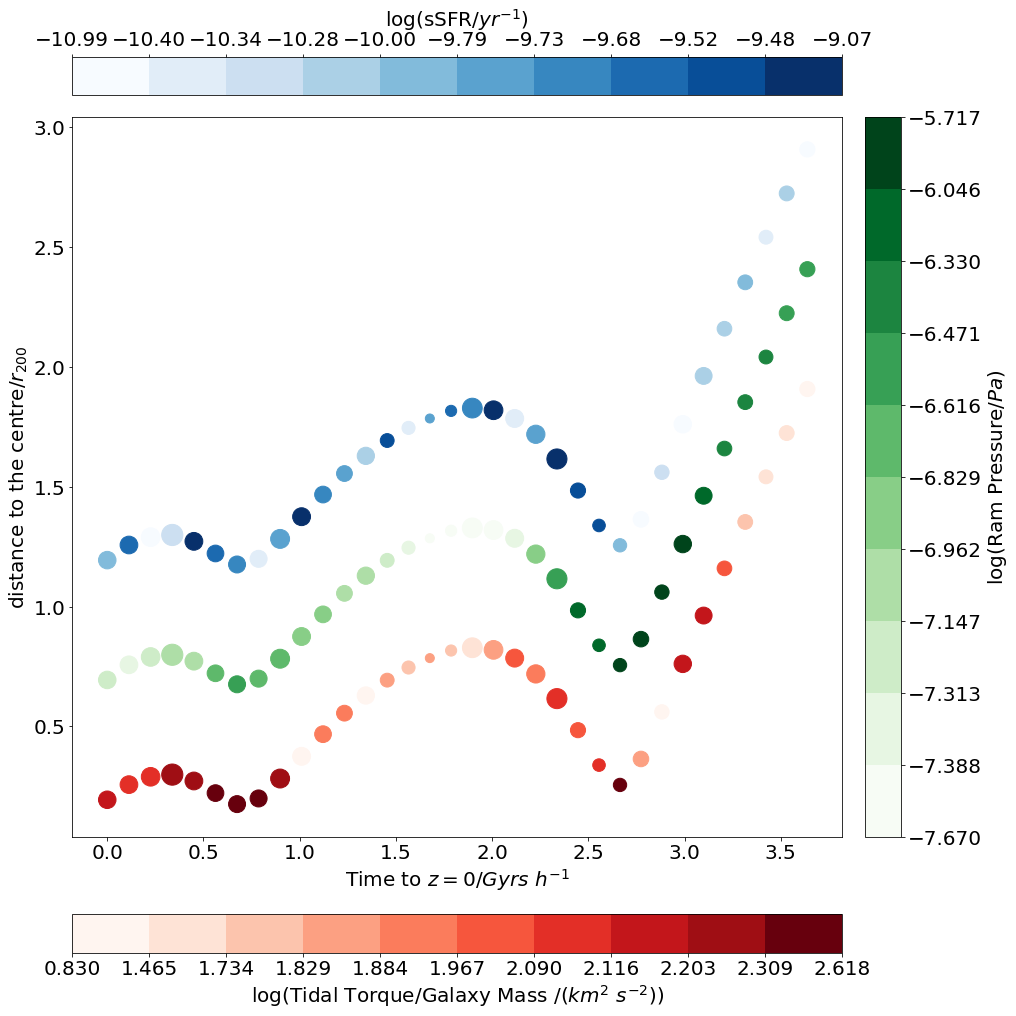

In [45]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4471/gMass_4471), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4471, dist_4471, s=p25G_4471*5000, c=np.log10(TSt_4471/gMass_4471), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4471), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4471, dist_4471+0.5, s=p25G_4471*5000, c=np.log10(RP_4471), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4471/starMass_4471)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4471, dist_4471+1., s=p25G_4471*5000, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

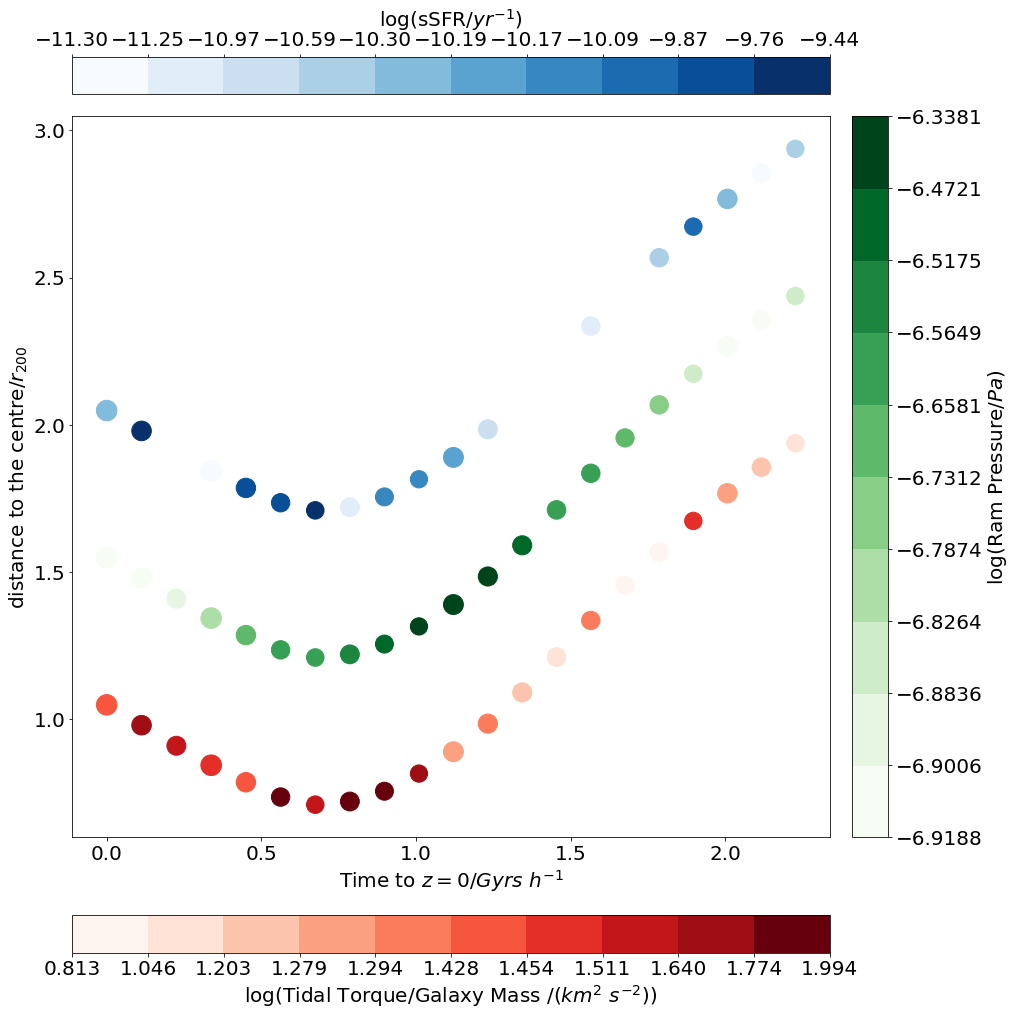

In [46]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4473/gMass_4473), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4473, dist_4473, s=p25G_4473*5000, c=np.log10(TSt_4473/gMass_4473), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4470), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4473, dist_4473+0.5, s=p25G_4473*5000, c=np.log10(RP_4473), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4473/starMass_4473)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4473, dist_4473+1., s=p25G_4473*5000, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

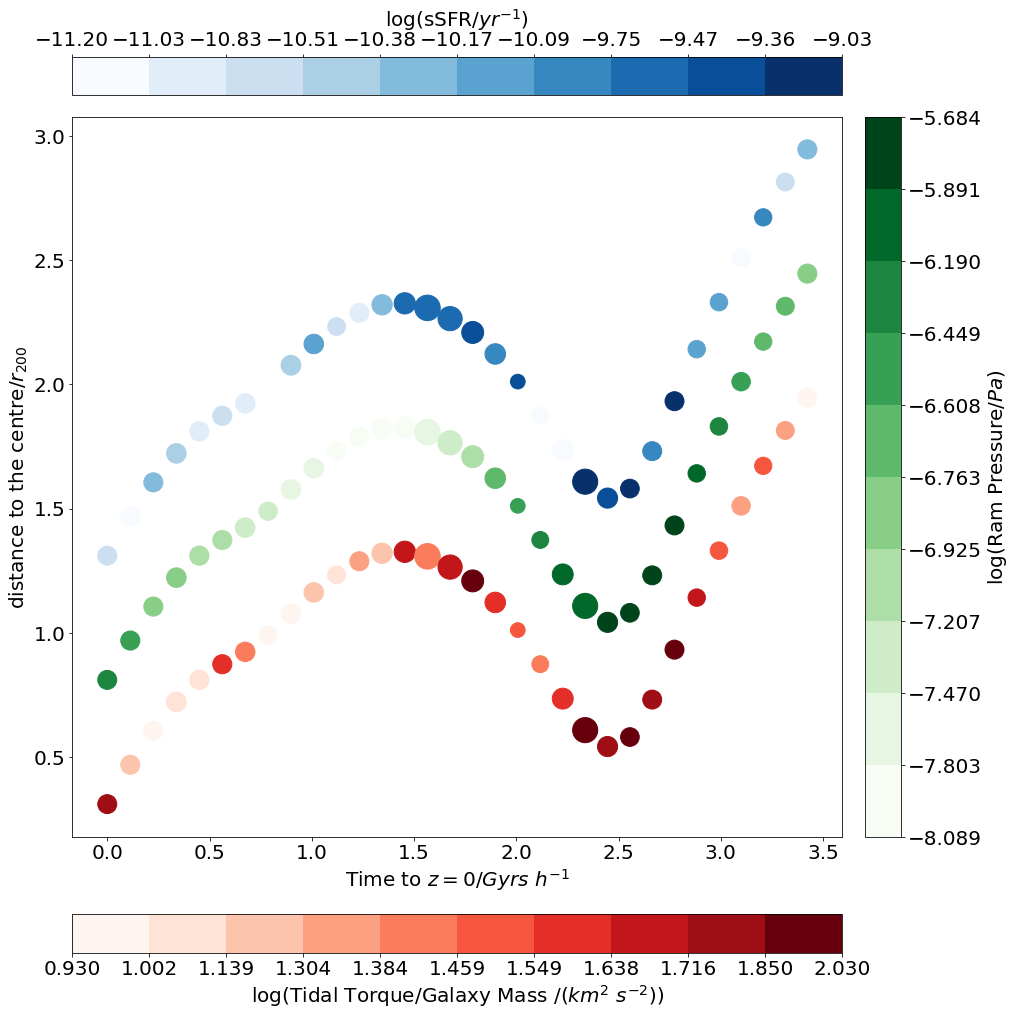

In [47]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4474/gMass_4474), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4474, dist_4474, s=p25G_4474*5000, c=np.log10(TSt_4474/gMass_4474), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4474), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4474, dist_4474+0.5, s=p25G_4474*5000, c=np.log10(RP_4474), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4474/starMass_4474)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4474, dist_4474+1., s=p25G_4474*5000, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

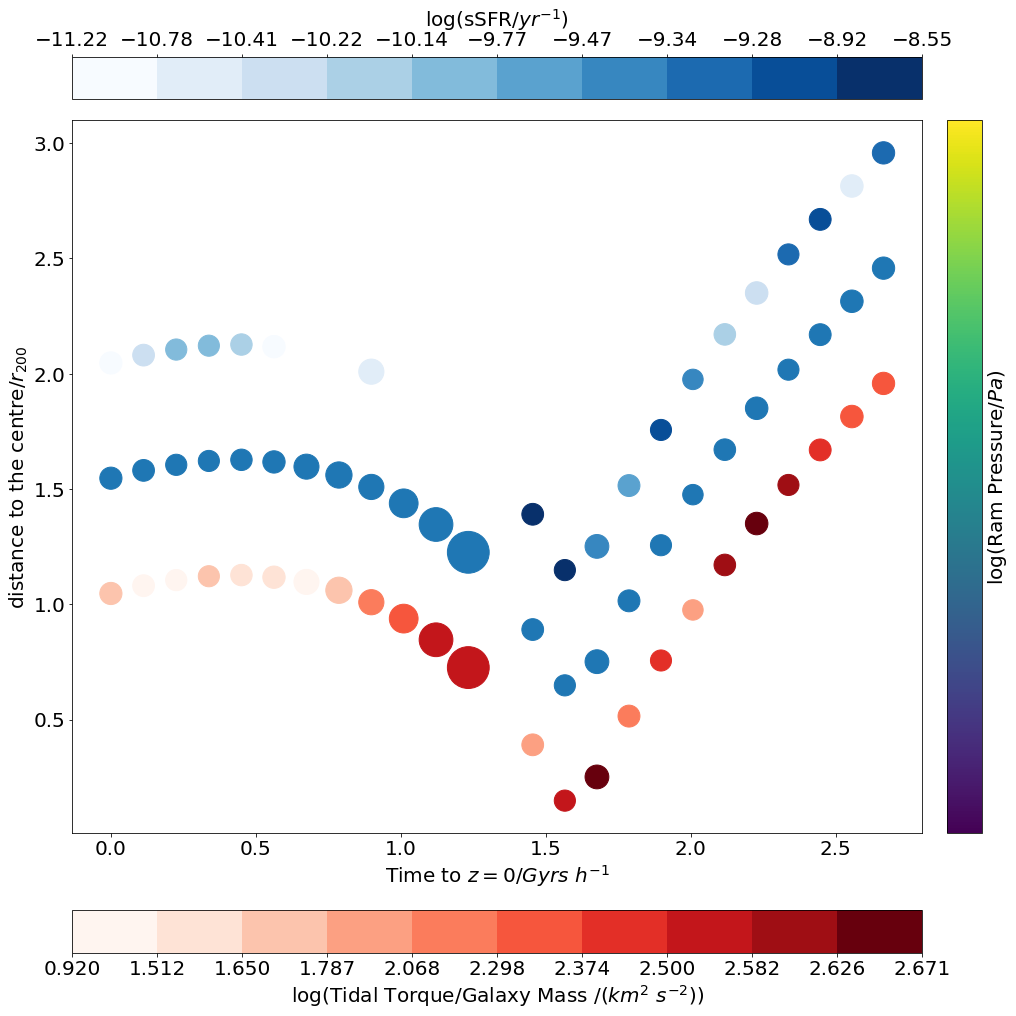

In [48]:
# ok, the ratio star/gas, just in case

pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4338/gMass_4338), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4338, dist_4338, s=(np.log10(rSG25_4338)+np.abs(np.min(np.log10(rSG25_4338))))*500, c=np.log10(TSt_4338/gMass_4338), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4338), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4338, dist_4338+0.5, s=(np.log10(rSG25_4338)+np.abs(np.min(np.log10(rSG25_4338))))*500, norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4338/starMass_4338)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4338, dist_4338+1., s=(np.log10(rSG25_4338)+np.abs(np.min(np.log10(rSG25_4338))))*500, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

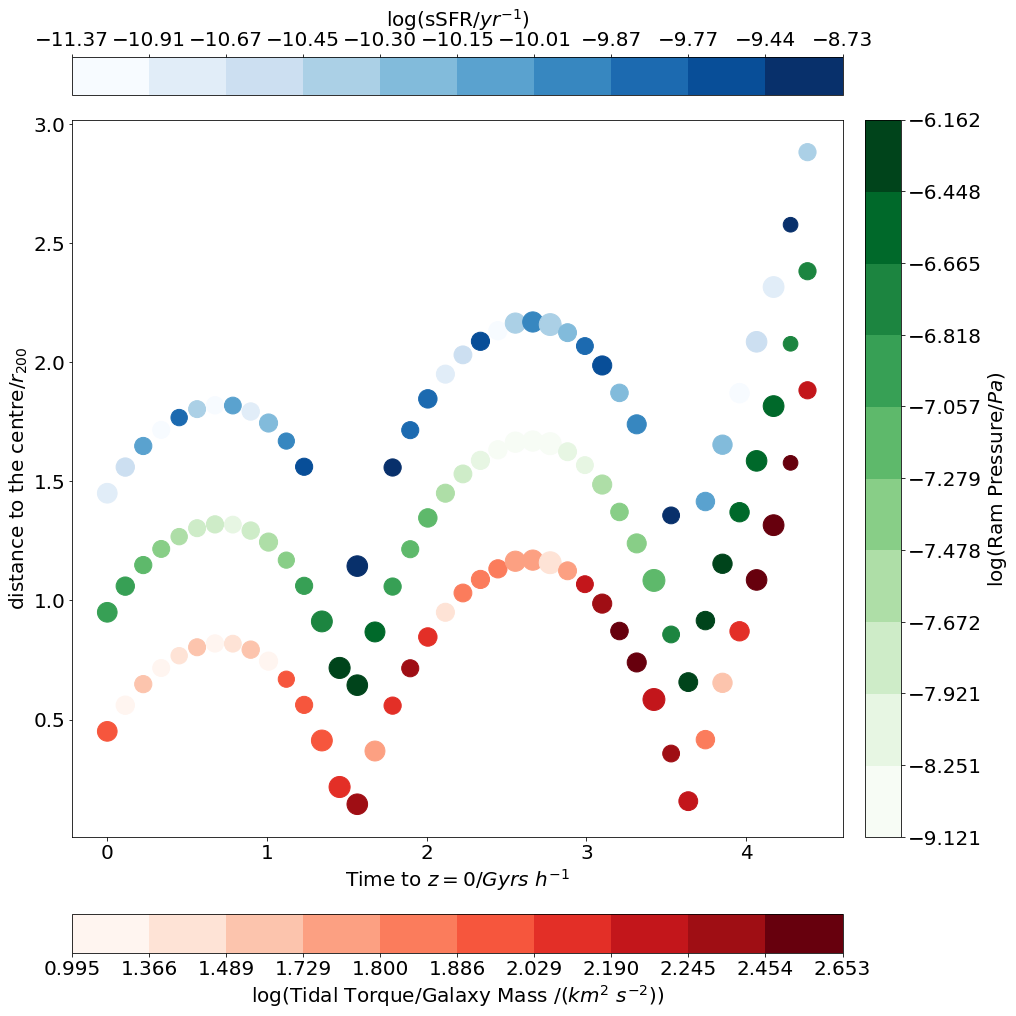

In [49]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4339/gMass_4339), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4339, dist_4339, s=(np.log10(rSG25_4339)+np.abs(np.min(np.log10(rSG25_4339))))*500, c=np.log10(TSt_4339/gMass_4339), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4339), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4339, dist_4339+0.5, s=(np.log10(rSG25_4339)+np.abs(np.min(np.log10(rSG25_4339))))*500, c=np.log10(RP_4339), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4339/starMass_4339)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4339, dist_4339+1., s=(np.log10(rSG25_4339)+np.abs(np.min(np.log10(rSG25_4339))))*500, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

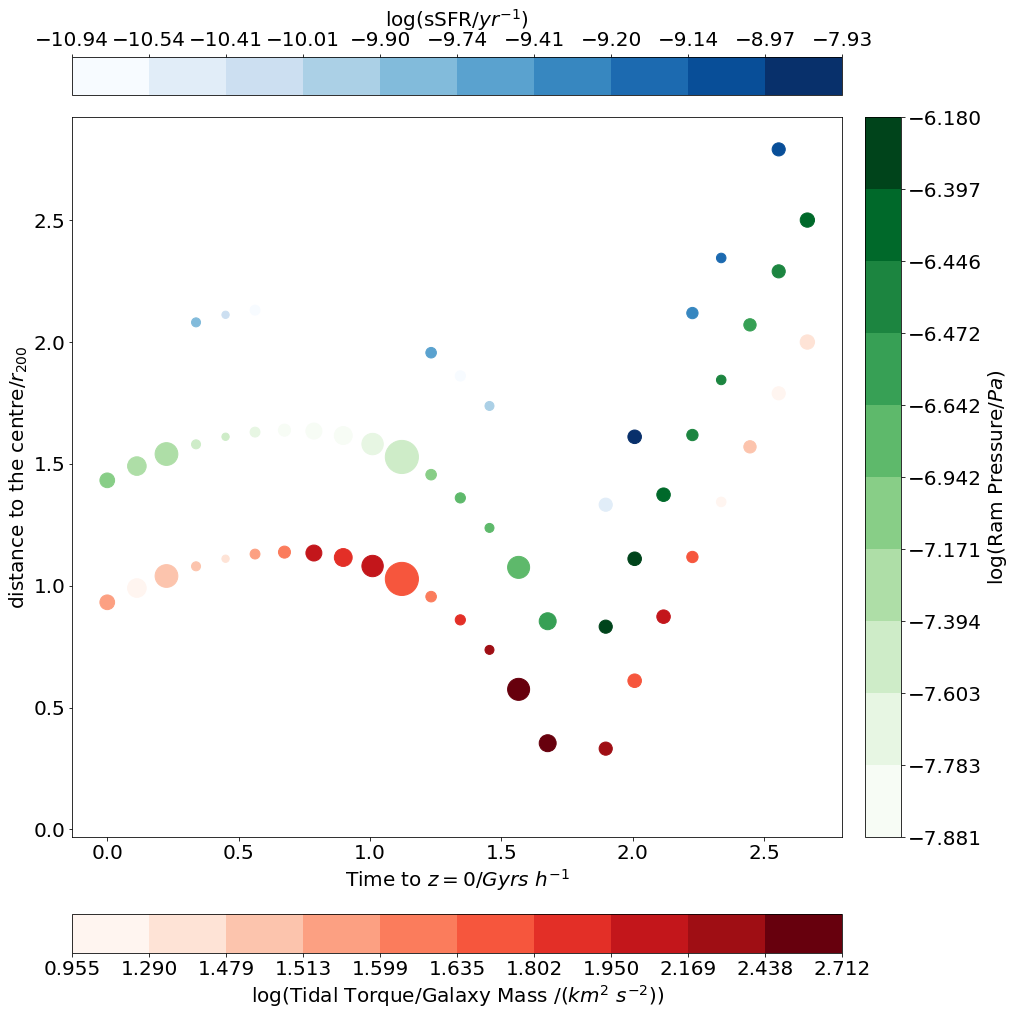

In [50]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4341/gMass_4341), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4341, dist_4341, s=(np.log10(rSG25_4341)+np.abs(np.min(np.log10(rSG25_4341))))*500, c=np.log10(TSt_4341/gMass_4341), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4341), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4341, dist_4341+0.5, s=(np.log10(rSG25_4341)+np.abs(np.min(np.log10(rSG25_4341))))*500, c=np.log10(RP_4341), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4341/starMass_4341)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4341, dist_4341+1., s=(np.log10(rSG25_4341)+np.abs(np.min(np.log10(rSG25_4341))))*500, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

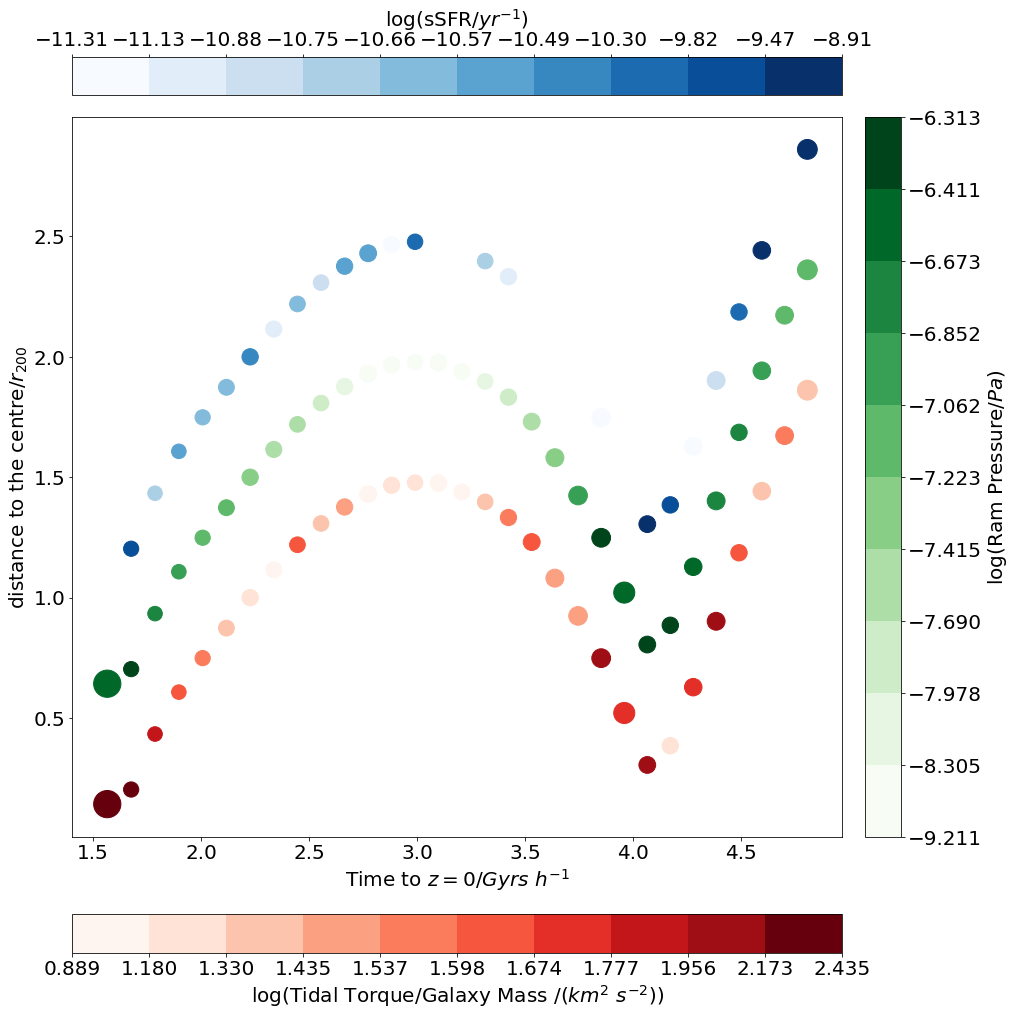

In [51]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4343/gMass_4343), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4343, dist_4343, s=(np.log10(rSG25_4343)+np.abs(np.min(np.log10(rSG25_4343))))*500, c=np.log10(TSt_4343/gMass_4343), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4343), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4343, dist_4343+0.5, s=(np.log10(rSG25_4343)+np.abs(np.min(np.log10(rSG25_4343))))*500, c=np.log10(RP_4343), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4343/starMass_4343)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4343, dist_4343+1., s=(np.log10(rSG25_4343)+np.abs(np.min(np.log10(rSG25_4343))))*500, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

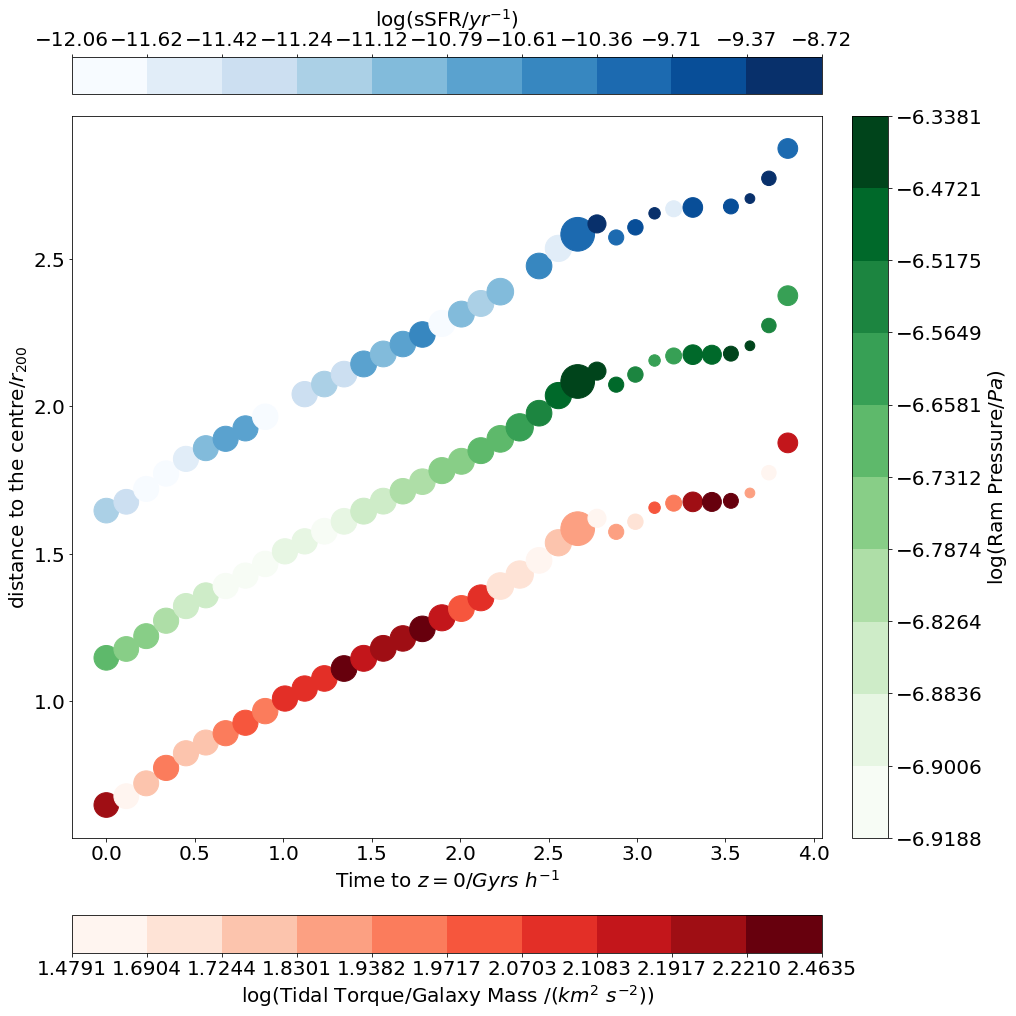

In [52]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4470/gMass_4470), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4470, dist_4470, s=(np.log10(rSG25_4470)+np.abs(np.min(np.log10(rSG25_4470))))*500, c=np.log10(TSt_4470/gMass_4470), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4470), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4470, dist_4470+0.5, s=(np.log10(rSG25_4470)+np.abs(np.min(np.log10(rSG25_4470))))*500, c=np.log10(RP_4470), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4470/starMass_4470)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4470, dist_4470+1., s=(np.log10(rSG25_4470)+np.abs(np.min(np.log10(rSG25_4470))))*500, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

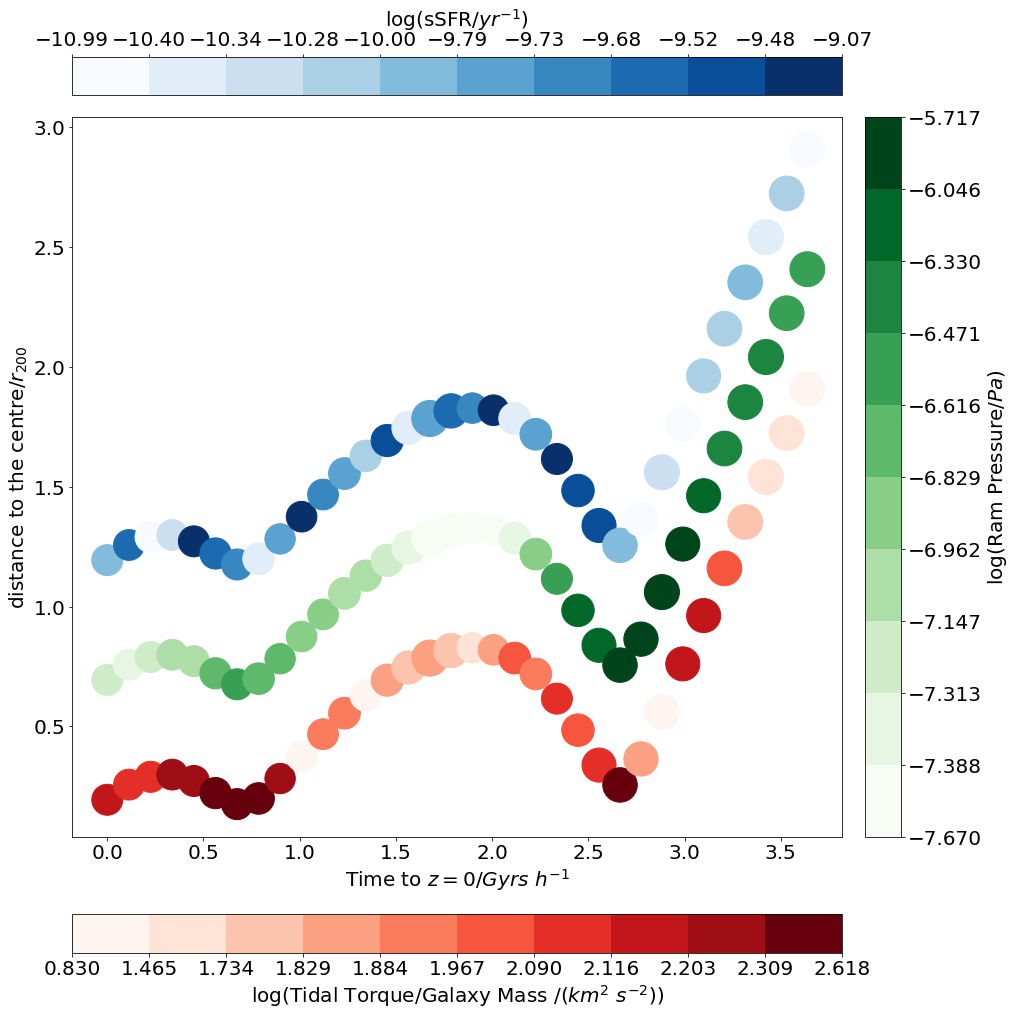

In [53]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4471/gMass_4471), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4471, dist_4471, s=(np.log10(rSG25_4471)+np.abs(np.min(np.log10(rSG25_4471))))*500, c=np.log10(TSt_4471/gMass_4471), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4471), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4471, dist_4471+0.5, s=(np.log10(rSG25_4471)+np.abs(np.min(np.log10(rSG25_4471))))*500, c=np.log10(RP_4471), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4471/starMass_4471)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4471, dist_4471+1., s=(np.log10(rSG25_4471)+np.abs(np.min(np.log10(rSG25_4471))))*500, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

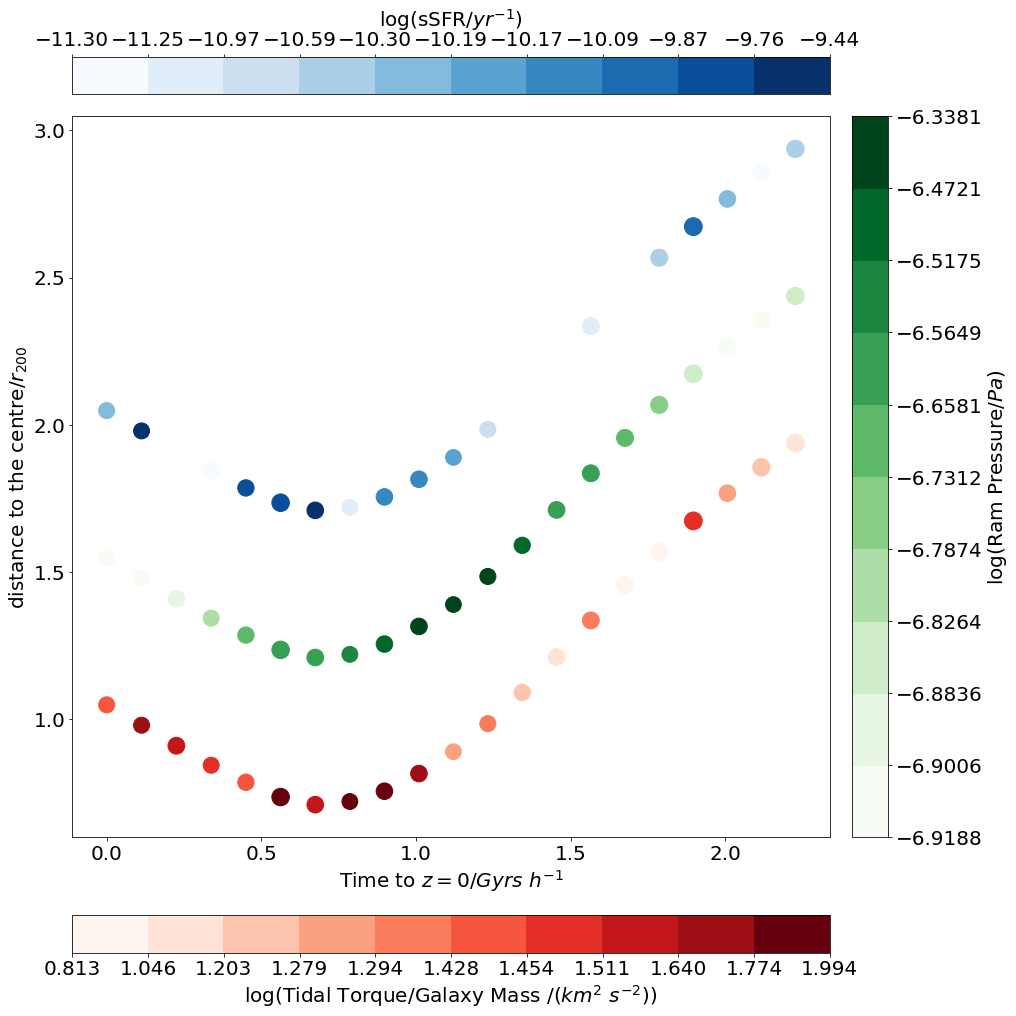

In [54]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4473/gMass_4473), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4473, dist_4473, s=(np.log10(rSG25_4473)+np.abs(np.min(np.log10(rSG25_4473))))*500, c=np.log10(TSt_4473/gMass_4473), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4470), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4473, dist_4473+0.5, s=(np.log10(rSG25_4473)+np.abs(np.min(np.log10(rSG25_4473))))*500, c=np.log10(RP_4473), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4473/starMass_4473)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4473, dist_4473+1., s=(np.log10(rSG25_4473)+np.abs(np.min(np.log10(rSG25_4473))))*500, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

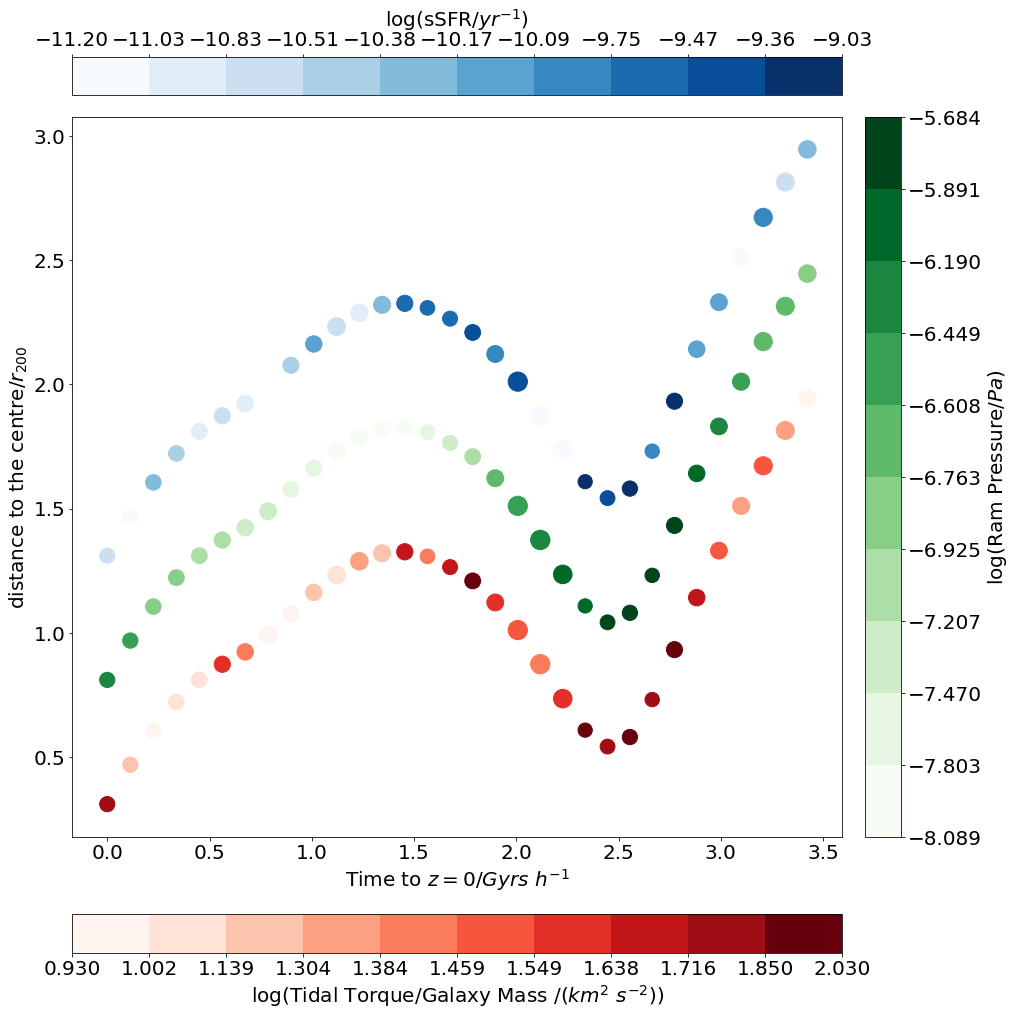

In [55]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4474/gMass_4474), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4474, dist_4474, s=(np.log10(rSG25_4474)+np.abs(np.min(np.log10(rSG25_4474))))*500, c=np.log10(TSt_4474/gMass_4474), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4474), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4474, dist_4474+0.5, s=(np.log10(rSG25_4474)+np.abs(np.min(np.log10(rSG25_4474))))*500, c=np.log10(RP_4474), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4474/starMass_4474)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4474, dist_4474+1., s=(np.log10(rSG25_4474)+np.abs(np.min(np.log10(rSG25_4474))))*500, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

In [56]:
np.log10(Mass1S_4338[0]+Mass5S_4338[0]+Mass25S_4338[0])

8.743230087476192

In [57]:
np.log10(Mass1S_4339[0]+Mass5S_4339[0]+Mass25S_4339[0])

8.314567522859052

In [58]:
np.log10(Mass1S_4341[0]+Mass5S_4341[0]+Mass25S_4341[0])

8.156263059248976

In [59]:
np.log10(Mass1S_4343[0]+Mass5S_4343[0]+Mass25S_4343[0])

8.020133069969624

In [60]:
np.log10(Mass1S_4470[0]+Mass5S_4470[0]+Mass25S_4470[0])

9.476142662184031

In [61]:
np.log10(Mass1S_4471[0]+Mass5S_4471[0]+Mass25S_4471[0])

9.479191435599448

In [62]:
np.log10(Mass1S_4473[0]+Mass5S_4473[0]+Mass25S_4473[0])

8.499857864703129

In [63]:
np.log10(Mass1S_4474[0]+Mass5S_4474[0]+Mass25S_4474[0])

8.634152122906

In [64]:
sim['SnapNumber_128/SubGroups/OpticalRadius'].attrs['description']

'Optical radii computed as the radius that encompass 83% of stellar and star-forming gas mass belonging to the SubGroup'

In [65]:
np.mean(RP_4338)

1.977247334410005e-07

In [66]:
np.mean(RP_4339)

1.286929170923313e-07

In [67]:
np.mean(RP_4341)

1.973105861058048e-07

In [68]:
np.mean(RP_4343)

1.2163132356276664e-07

In [69]:
np.mean(RP_4470)

2.2115028882758812e-07

In [70]:
np.mean(RP_4471)

3.433610193775156e-07

In [71]:
np.mean(RP_4473)

2.1722239315936425e-07

In [72]:
np.mean(RP_4474)

3.9645221619692894e-07

In [73]:
i = np.where(dist_4338<=1)
np.mean(RP_4338[i])

3.226083576779151e-07

In [74]:
i = np.where(dist_4339<=1)
np.mean(RP_4339[i])

1.5289066823515369e-07

In [75]:
i = np.where(dist_4341<=1)
np.mean(RP_4341[i])

2.6665297683905545e-07

In [76]:
i = np.where(dist_4343<=1)
np.mean(RP_4343[i])

1.7443236318939826e-07

In [77]:
i = np.where(dist_4470<=1)
np.mean(RP_4470[i])

1.50339403413269e-07

In [78]:
i = np.where(dist_4471<=1)
np.mean(RP_4471[i])

3.391569570035952e-07

In [79]:
i = np.where(dist_4473<=1)
np.mean(RP_4473[i])

2.471532111662972e-07

In [80]:
i = np.where(dist_4474<=1)
np.mean(RP_4474[i])

6.283122453586777e-07

In [88]:
np.mean(TSt_4338/gMass_4338)

204.5940763219483

In [89]:
np.mean(TSt_4339/gMass_4339)

124.01357287378323

In [90]:
np.mean(TSt_4341/gMass_4341)

108.84791062911572

In [91]:
np.mean(TSt_4343/gMass_4343)

64.78312790636781

In [92]:
np.mean(TSt_4470/gMass_4470)

106.61709840423796

In [93]:
np.mean(TSt_4471/gMass_4471)

115.97406048622116

In [94]:
np.mean(TSt_4473/gMass_4473)

32.41437934494915

In [95]:
np.mean(TSt_4474/gMass_4474)

36.23780902614169

In [97]:
# I need teh gas mass, by the way
print(starMass_4338[0]/starMass_4338[-1])
print(starMass_4339[0]/starMass_4339[-1])
print(starMass_4341[0]/starMass_4341[-1])
print(starMass_4343[0]/starMass_4343[-1])

print(starMass_4470[0]/starMass_4470[-1])
print(starMass_4471[0]/starMass_4471[-1])
print(starMass_4473[0]/starMass_4473[-1])
print(starMass_4474[0]/starMass_4474[-1])

1.8303316027544452
1.4011494598019374
1.6030031941630285
0.47401138789771813
3.1208695021951254
1.9013955417221116
1.1038527855042084
1.6388679182973944


In [115]:
def gasRatio(gal, central):
    uniqueID = int(127*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(127*1e6+central)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][central]
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
    MassGG = []
    
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snap, iddC = split_unique_id(int(mC))
        
        optRad = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        cenPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        
        delta = galPos - cenPos
        r = np.sqrt(np.sum(delta**2.))
        
        if r>2*r200:
            break
        
        offGas = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        MassG = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][offGas[0]:offGas[1]]
        posG = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][offGas[0]:offGas[1]]
        XG, YG, ZG = posG[:,0] - galPos[0], posG[:,1] - galPos[1], posG[:,2] - galPos[2]
        rG = np.sqrt(XG**2+YG**2+ZG**2)
        
        iG = np.where(rG<optRad)[0]
        
        MassGG.append(np.sum(MassG[iG])*1e10)
        
    MassGG = np.array(MassGG)
    
    return MassGG[0]/MassGG[-1]

In [117]:
print(gasRatio(4338,4337))
print(gasRatio(4339,4337))
print(gasRatio(4341,4337))
print(gasRatio(4343,4337))

print(gasRatio(4470,4469))
print(gasRatio(4471,4469))
print(gasRatio(4473,4469))
print(gasRatio(4474,4469))

0.29760751631343024
0.3697273997848734
0.25703136680238287
0.0
0.6550777841773081
4.992078684041108
0.9794969194753378
2.066615387440398
